**Name:** Tan Wan Xuen <br>
**Student ID:** 2207214  <br>
**Project Title:** Machine Learning-Driven Predictive Loan Repayment Behavior <br>
**Notebook:** Model Training and Fairness Adjustment <br>
**Overview:** In this notebook, model training for Logistic Regression, LightGBM, and CatBoost is performed, followed by hyperparameter tuning. Once the models with the best performance are obtained, fairness evaluation and adjustment, including pre-processing, in-processing, and post-processing, are implemented. Upon completing the fairness analysis, the best fairness-aware model is chosen and saved. 
<br><br>
1.0 Read datasets <br>
2.0 Class Imbalance Handling <br>
3.0 Model Training <br>
4.0 Hyperparameter Tuning <br>
5.0 Model Intepretation <br>
6.0 Model Evaluation <br>
7.0 Fairness Pre-processing <br>
8.0 Fairness In-processing <br>
9.0 Fairness Post-processing <br>

In [1]:
import pandas as pd
import numpy as np
import os
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler

from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer


In [2]:
# File paths
DATASET_DIR = "../datasets"
RESOURCES_DIR = "../resources"

# Target variable
TARGET = "target"

## 1.0 Read datasets

In [3]:
# Read the train, test and validation datasets
df_train = pd.read_parquet(os.path.join(DATASET_DIR, 'Train_Set'))
df_test = pd.read_parquet(os.path.join(DATASET_DIR, 'Test_Set'))
df_val = pd.read_parquet(os.path.join(DATASET_DIR, 'Validation_Set'))

In [4]:
print("Train set size: ", df_train.shape)
print("Test set size: ", df_test.shape)
print("Validation set size: ", df_val.shape)

Train set size:  (7787473, 33)
Test set size:  (2595825, 33)
Validation set size:  (2595825, 33)


In [5]:
X_train = df_train.drop(TARGET, axis=1)
y_train = df_train[TARGET]

X_test = df_test.drop(TARGET, axis=1)
y_test = df_test[TARGET]

X_val = df_val.drop(TARGET, axis=1)
y_val = df_val[TARGET]

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787473 entries, 0 to 7787472
Data columns (total 32 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   cur_actual_UPB                 float64
 1   cur_int_rate                   float64
 2   cur_deferred_UPB               float64
 3   ELTV                           float64
 4   credit_score                   float64
 5   MI(%)                          float64
 6   num_of_units                   float64
 7   ori_DTI                        float64
 8   num_borrowers                  float64
 9   loan_age                       float64
 10  first_time_homebuyer_Y         float64
 11  occupancy_status_P             float64
 12  occupancy_status_S             float64
 13  channel_B                      float64
 14  channel_C                      float64
 15  channel_R                      float64
 16  property_type_CP               float64
 17  property_type_MH               float64
 18  pr

---

## 2.0 Class Imbalance Handling
Random under sampling is carried out. 

In [7]:
# Perform under sampling
random = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = random.fit_resample(X_train, y_train)

print(f'Original class distribution:\n{y_train.value_counts()}')
print(f'Balanced class distribution:\n{y_resampled.value_counts()}')

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Original class distribution:
target
True     7761630
False      25843
Name: count, dtype: int64
Balanced class distribution:
target
False    25843
True     25843
Name: count, dtype: int64


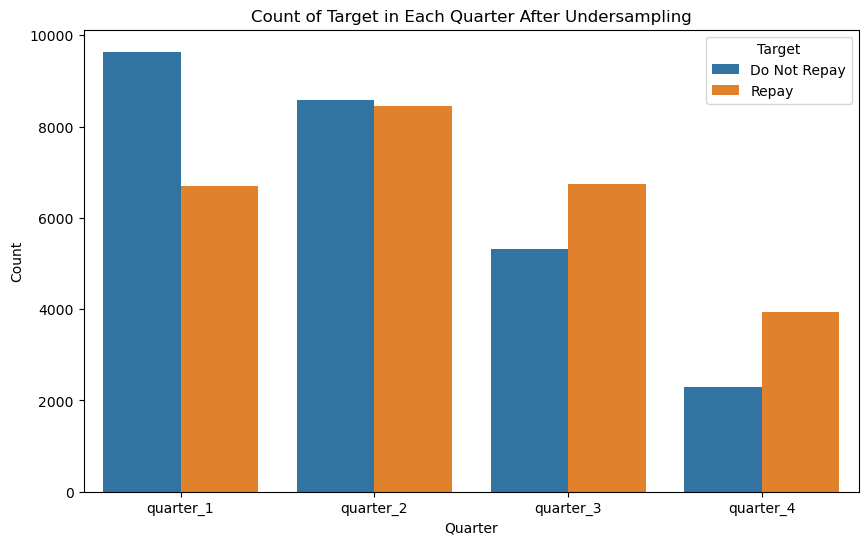

In [8]:
# Visualise the class distribution in each quarters
df_quarters = X_resampled[['quarter_2', 'quarter_3', 'quarter_4']].copy()
df_quarters['target'] = y_resampled 
df_quarters['quarter_1'] = (df_quarters[['quarter_2', 'quarter_3', 'quarter_4']].sum(axis=1) == 0).astype(int)

df_melted = df_quarters.melt(id_vars=['target'], var_name='Quarter', value_name='Presence')

# Keep only active quarters
df_melted = df_melted[df_melted['Presence'] == 1]

plt.figure(figsize=(10, 6))
sns.countplot(x='Quarter', hue='target', data=df_melted, order=['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'])
plt.title('Count of Target in Each Quarter After Undersampling')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right', labels=['Do Not Repay','Repay'])
plt.show()


---

## 3.0 Model Training
Logistic Regression, LightGBM and CatBoost are trained. 

In [9]:
def print_result(model, X_sample, X_sample_val, X_sample_test):
    train_pred = model.predict(X_sample)
    val_pred = model.predict(X_sample_val)
    y_pred = model.predict(X_sample_test)

    # Confusion Matrix
    conf_matrix_val = confusion_matrix(y_val, val_pred)
    conf_matrix_test = confusion_matrix(y_test, y_pred)
    conf_matrix_train = confusion_matrix(y_resampled, train_pred)

    # Accuracy
    train_acc = accuracy_score(y_resampled, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, y_pred)

    # Predictions
    train_pred_proba = model.predict_proba(X_sample)[:, 1]
    val_pred_proba = model.predict_proba(X_sample_val)[:, 1]
    test_pred_proba = model.predict_proba(X_sample_test)[:, 1]

    # Precision
    train_precision = precision_score(y_resampled, train_pred)
    val_precision = precision_score(y_val, val_pred)
    test_precision = precision_score(y_test, y_pred)

    # Recall
    train_recall = recall_score(y_resampled, train_pred)
    val_recall = recall_score(y_val, val_pred)
    test_recall = recall_score(y_test, y_pred)

    # F1 Score
    train_f1 = f1_score(y_resampled, train_pred)
    val_f1 = f1_score(y_val, val_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    # ROC AUC Score
    val_auc = roc_auc_score(y_val, val_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    train_auc = roc_auc_score(y_resampled, train_pred_proba)

    # G-Mean
    val_gmean = geometric_mean_score(y_val, val_pred)
    test_gmean = geometric_mean_score(y_test, y_pred)
    train_gmean = geometric_mean_score(y_resampled, train_pred)

    TN_train, FP_train= conf_matrix_train[0][0], conf_matrix_train[0][1]
    TN_val, FP_val= conf_matrix_val[0][0], conf_matrix_val[0][1]
    TN_test, FP_test= conf_matrix_test[0][0], conf_matrix_test[0][1]
    
    # Specificity
    specificity_train = TN_train / (TN_train + FP_train)
    specificity_val = TN_val / (TN_val + FP_val)
    specificity_test = TN_test / (TN_test + FP_test)

    print("Classification report of train set\n", classification_report (y_resampled, train_pred))
    print("Classification report of validation set\n",classification_report (y_val, val_pred))
    print("Classification report of test set\n", classification_report (y_test, y_pred))

    print(f"\nTrain Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    print(f"\nTrain Specificity: {specificity_train:.4f}")
    print(f"Validation Specificity: {specificity_val:.4f}")
    print(f"Test Specificity: {specificity_test:.4f}")

    print(f"\nTrain Precision: {train_precision:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Test Precision: {test_precision:.4f}")

    print(f"\nTrain Recall: {train_recall:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    print(f"\nTrain F1 Score: {train_f1:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    print(f"\nTrain AUC: {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    print("\nConfusion Matrix of train set:\n", conf_matrix_train)
    print("\nConfusion Matrix of validation set:\n", conf_matrix_val)
    print("\nConfusion Matrix of test set:\n", conf_matrix_test)

    print(f'\nGeometric Mean (G-Mean) of train set: {val_gmean:.4f}')
    print(f'Geometric Mean (G-Mean) of validation set: {test_gmean:.4f}')
    print(f'Geometric Mean (G-Mean) of test set: {train_gmean:.4f}')
    

### 3.1 Logistic Regression

In [10]:
logReg = LogisticRegression(random_state=42)
logReg.fit(X_resampled, y_resampled)

print_result(logReg,X_resampled, X_val, X_test)

Classification report of train set
               precision    recall  f1-score   support

       False       0.78      0.81      0.79     25843
        True       0.80      0.77      0.78     25843

    accuracy                           0.79     51686
   macro avg       0.79      0.79      0.79     51686
weighted avg       0.79      0.79      0.79     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.81      0.02      8736
        True       1.00      0.76      0.86   2587089

    accuracy                           0.76   2595825
   macro avg       0.51      0.79      0.44   2595825
weighted avg       1.00      0.76      0.86   2595825

Classification report of test set
               precision    recall  f1-score   support

       False       0.01      0.81      0.02      8773
        True       1.00      0.76      0.86   2587052

    accuracy                           0.76   2595825
   macro avg    

### 3.2 LightGBM

In [11]:
lgb_params = {
    "objective": "binary",      
    "boosting_type": "gbdt",    # Gradient Boosting Decision Tree           
    "metric": "auc",
    "random_seed": 42,
    "verbose": 1               
}
                            
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_resampled, y_resampled)

print_result(lgb_model,X_resampled, X_val, X_test)

[LightGBM] [Info] Number of positive: 25843, number of negative: 25843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 51686, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification report of train set
               precision    recall  f1-score   support

       False       0.81      0.86      0.83     25843
        True       0.85      0.79      0.82     25843

    accuracy                           0.83     51686
   macro avg       0.83      0.83      0.83     51686
weighted avg       0.83      0.83      0.83     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.84     

### 3.3 Catboost

In [12]:
cat_model=CatBoostClassifier(
    iterations=200,
    random_seed=42,
    use_best_model=True,
    eval_metric="AUC",
)
cat_model.fit(X_resampled, y_resampled,
          eval_set=(X_val, y_val),
          plot=True)

print_result(cat_model,X_resampled, X_val, X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.169108
0:	test: 0.8314656	best: 0.8314656 (0)	total: 702ms	remaining: 2m 19s
1:	test: 0.8420501	best: 0.8420501 (1)	total: 1.12s	remaining: 1m 51s
2:	test: 0.8461051	best: 0.8461051 (2)	total: 1.58s	remaining: 1m 43s
3:	test: 0.8511713	best: 0.8511713 (3)	total: 2.05s	remaining: 1m 40s
4:	test: 0.8543327	best: 0.8543327 (4)	total: 2.5s	remaining: 1m 37s
5:	test: 0.8586294	best: 0.8586294 (5)	total: 2.94s	remaining: 1m 35s
6:	test: 0.8617962	best: 0.8617962 (6)	total: 3.41s	remaining: 1m 34s
7:	test: 0.8629671	best: 0.8629671 (7)	total: 3.86s	remaining: 1m 32s
8:	test: 0.8641910	best: 0.8641910 (8)	total: 4.29s	remaining: 1m 30s
9:	test: 0.8647060	best: 0.8647060 (9)	total: 4.7s	remaining: 1m 29s
10:	test: 0.8651416	best: 0.8651416 (10)	total: 5.15s	remaining: 1m 28s
11:	test: 0.8658964	best: 0.8658964 (11)	total: 5.6s	remaining: 1m 27s
12:	test: 0.8662721	best: 0.8662721 (12)	total: 5.99s	remaining: 1m 26s
13:	test: 0.8671045	best: 0.8671045 (13)	total: 6.39s	rem

---
## 4.0 Hyperparameter Tuning
Hyperparameter tuning by Optuna is carried out. After that, the best parameters of each models are obtained. All the models with their best parameters are trained and evaluated to obtain the best model.
### 4.1 Logistic Regression

In [13]:
def objective_lr(trial):
    params = {
        "random_state": 42,
        #"class_weight": "balanced",
        "solver": trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'saga']),
        "max_iter": trial.suggest_int("max_iter", 100, 1000, step=50),
        "C": trial.suggest_float("C", 0.01, 10.0, log=True)
    }

    model = LogisticRegression(**params)
     
    model.fit(X_resampled, y_resampled)
    y_pred_proba = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_proba)
    
    return accuracy

study_lr = optuna.create_study(storage="sqlite:///tuning.sqlite3", study_name="LogisticRegression", direction="maximize")
study_lr.optimize(objective_lr, n_trials=20, show_progress_bar=True)

best_params_lr = study_lr.best_trial.params

print("Best parameters:", best_params_lr)
print("Best accuracy score:", study_lr.best_value)

[I 2025-04-06 08:21:25,783] A new study created in RDB with name: LogisticRegression


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-06 08:21:26,980] Trial 0 finished with value: 0.7622462993460654 and parameters: {'solver': 'liblinear', 'max_iter': 650, 'C': 2.307884085561999}. Best is trial 0 with value: 0.7622462993460654.
[I 2025-04-06 08:21:27,974] Trial 1 finished with value: 0.759082372656092 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'C': 0.09104518568558874}. Best is trial 0 with value: 0.7622462993460654.
[I 2025-04-06 08:21:28,877] Trial 2 finished with value: 0.7618687700442056 and parameters: {'solver': 'liblinear', 'max_iter': 300, 'C': 0.6588252689861863}. Best is trial 0 with value: 0.7622462993460654.
[I 2025-04-06 08:21:29,742] Trial 3 finished with value: 0.7618402627295754 and parameters: {'solver': 'liblinear', 'max_iter': 850, 'C': 0.6321388695595747}. Best is trial 0 with value: 0.7622462993460654.
[I 2025-04-06 08:21:31,346] Trial 4 finished with value: 0.7615270675026244 and parameters: {'solver': 'saga', 'max_iter': 900, 'C': 0.39672213237667137}. Best is trial 0 with v

In [14]:
logReg_best= LogisticRegression(**best_params_lr)
logReg_best.fit(X_resampled, y_resampled)

LogisticRegression(C=9.044635025277646, max_iter=1000, solver='liblinear')

### 4.2 LightGBM

In [ ]:
def objective_lgb(trial):
    params = {
        "objective": "binary",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "rf", "dart"]),
        "metric": "auc",
        "verbose": -1,
        "random_seed": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),  # Ensuring valid bagging frequency
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),  # Ensuring valid fraction
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_resampled, y_resampled, 
        eval_set=[(X_val, y_val)], 
        eval_metric="auc"
    )

    y_pred_proba = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_proba)

    return accuracy

study_lgb = optuna.create_study(storage="sqlite:///tuning.sqlite3", study_name="LightGBM", direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=20, show_progress_bar=True)

best_params_lgb = study_lgb.best_trial.params

print("Best parameters:", best_params_lgb)
print("Best accuracy score:", study_lgb.best_value)


[I 2025-04-06 08:21:51,581] A new study created in RDB with name: LightGBM


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-06 08:22:27,041] Trial 0 finished with value: 0.7498375275683068 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03597825665973037, 'max_depth': 4, 'bagging_freq': 2, 'bagging_fraction': 0.6691972541024103}. Best is trial 0 with value: 0.7498375275683068.
[I 2025-04-06 08:22:57,854] Trial 1 finished with value: 0.7483204761492012 and parameters: {'boosting_type': 'rf', 'learning_rate': 0.05900480877302969, 'max_depth': 14, 'bagging_freq': 10, 'bagging_fraction': 0.407870481564957}. Best is trial 0 with value: 0.7498375275683068.
[I 2025-04-06 08:23:26,068] Trial 2 finished with value: 0.7454539500929377 and parameters: {'boosting_type': 'rf', 'learning_rate': 0.11339402644265788, 'max_depth': 7, 'bagging_freq': 5, 'bagging_fraction': 0.786705695500861}. Best is trial 0 with value: 0.7498375275683068.
[I 2025-04-06 08:24:24,826] Trial 3 finished with value: 0.7787169782246492 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.29190325381853116, 'max_dep

In [16]:
lgb_model_best = lgb.LGBMClassifier(**best_params_lgb)
lgb_model_best.fit(X_resampled, y_resampled)

LGBMClassifier(bagging_fraction=0.711726939754358, bagging_freq=8,
               learning_rate=0.21736680731470062, max_depth=7)

### 4.3 Catboost

In [ ]:
def objective_cat(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "iterations": 200,
        "random_seed": 42,
        "eval_metric": "AUC",  
        "use_best_model": True,

        # Regularization 
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0),  # L2 regularization
        "border_count": trial.suggest_int("border_count", 32, 255),  # Feature binning for better generalization
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_resampled, y_resampled,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    y_pred_proba = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_proba)
    
    return accuracy

study_cat = optuna.create_study(storage="sqlite:///tuning.sqlite3", study_name="Catboost2", direction="maximize")
study_cat.optimize(objective_cat, n_trials=20, show_progress_bar=True)

best_params_cat = study_cat.best_trial.params

print("Best parameters:", best_params_cat)
print("Best accuracy score:", study_cat.best_value)


[I 2025-04-06 11:41:53,263] A new study created in RDB with name: Catboost2


  0%|          | 0/20 [00:00<?, ?it/s]

0:	test: 0.8314656	best: 0.8314656 (0)	total: 319ms	remaining: 1m 3s
1:	test: 0.8460759	best: 0.8460759 (1)	total: 497ms	remaining: 49.2s
2:	test: 0.8530372	best: 0.8530372 (2)	total: 692ms	remaining: 45.4s
3:	test: 0.8556478	best: 0.8556478 (3)	total: 853ms	remaining: 41.8s
4:	test: 0.8570795	best: 0.8570795 (4)	total: 1.05s	remaining: 41s
5:	test: 0.8594684	best: 0.8594684 (5)	total: 1.24s	remaining: 39.9s
6:	test: 0.8609890	best: 0.8609890 (6)	total: 1.44s	remaining: 39.7s
7:	test: 0.8627322	best: 0.8627322 (7)	total: 1.61s	remaining: 38.8s
8:	test: 0.8634605	best: 0.8634605 (8)	total: 1.8s	remaining: 38.3s
9:	test: 0.8641170	best: 0.8641170 (9)	total: 1.97s	remaining: 37.4s
10:	test: 0.8652075	best: 0.8652075 (10)	total: 2.13s	remaining: 36.6s
11:	test: 0.8658567	best: 0.8658567 (11)	total: 2.28s	remaining: 35.8s
12:	test: 0.8668449	best: 0.8668449 (12)	total: 2.47s	remaining: 35.6s
13:	test: 0.8676002	best: 0.8676002 (13)	total: 2.64s	remaining: 35.1s
14:	test: 0.8684711	best: 0.8

In [55]:
cat_model_best=CatBoostClassifier(**best_params_cat, iterations=200)
cat_model_best.fit(X_resampled, y_resampled,
          eval_set=(X_val, y_val),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5914772	test: 0.5871966	best: 0.5871966 (0)	total: 109ms	remaining: 21.8s
1:	learn: 0.5316471	test: 0.5288404	best: 0.5288404 (1)	total: 223ms	remaining: 22.1s
2:	learn: 0.5005397	test: 0.5022600	best: 0.5022600 (2)	total: 335ms	remaining: 22s
3:	learn: 0.4781188	test: 0.4811109	best: 0.4811109 (3)	total: 446ms	remaining: 21.9s
4:	learn: 0.4683698	test: 0.4766015	best: 0.4766015 (4)	total: 567ms	remaining: 22.1s
5:	learn: 0.4625090	test: 0.4751001	best: 0.4751001 (5)	total: 666ms	remaining: 21.5s
6:	learn: 0.4575932	test: 0.4729254	best: 0.4729254 (6)	total: 779ms	remaining: 21.5s
7:	learn: 0.4546837	test: 0.4719803	best: 0.4719803 (7)	total: 874ms	remaining: 21s
8:	learn: 0.4522560	test: 0.4710584	best: 0.4710584 (8)	total: 977ms	remaining: 20.7s
9:	learn: 0.4497606	test: 0.4699136	best: 0.4699136 (9)	total: 1.08s	remaining: 20.6s
10:	learn: 0.4474623	test: 0.4688217	best: 0.4688217 (10)	total: 1.18s	remaining: 20.3s
11:	learn: 0.4457569	test: 0.4676333	best: 0.4676333 (11

---
## 5.0 Model Interpretation
Feature importance analysis by SHAP is performed. 

In [19]:
def plot_summary(shap_values, title):
    print("\n", title)
    shap.plots.bar(shap_values, max_display=15)

def plot_waterfall(shap_values, title):
    print("\n", title)
    shap.waterfall_plot(shap_values[0])

def feature_importance_tree(model,X_val_sample, X_test_sample):
    explainer = shap.TreeExplainer(model) 

    shap_values_val=explainer(X_val_sample)
    shap_values_test=explainer(X_test_sample)
    
    plot_summary(shap_values_val, 'Validation Set')
    plot_summary(shap_values_test, 'Test Set')
    plot_waterfall(shap_values_val, 'Validation Set')
    plot_waterfall(shap_values_test, 'Test Set')

def feature_importance_linear(model, X_true, X_val_sample, X_test_sample):
    explainer = shap.LinearExplainer(model, X_true) 

    shap_values_val=explainer(X_val_sample)
    shap_values_test=explainer(X_test_sample)

    plot_summary(shap_values_val, 'Validation Set')
    plot_summary(shap_values_test, 'Test Set')
    plot_waterfall(shap_values_val, 'Validation Set')
    plot_waterfall(shap_values_test, 'Test Set')

def feature_importance_linear_in_processing(model, X_true):
    final_model = list(model.predictors_)[-1]  
    explainer = shap.LinearExplainer(final_model, X_true) 

    shap_values_val=explainer(X_val)
    shap_values_test=explainer(X_test)

    plot_summary(shap_values_val, 'Validation Set')
    plot_summary(shap_values_test, 'Test Set')
    plot_waterfall(shap_values_val, 'Validation Set')
    plot_waterfall(shap_values_test, 'Test Set')

def feature_importance_tree_in_processing(model):
    final_model = list(model.predictors_)[-1] 
    explainer = shap.TreeExplainer(final_model) 

    shap_values_val=explainer(X_val)
    shap_values_test=explainer(X_test)

    plot_summary(shap_values_val, 'Validation Set')
    plot_summary(shap_values_test, 'Test Set')
    plot_waterfall(shap_values_val, 'Validation Set')
    plot_waterfall(shap_values_test, 'Test Set')


LinearExplainer explainer: 2595826it [00:25, 60549.97it/s]                              
LinearExplainer explainer: 2595826it [00:24, 61140.05it/s]                              



 Validation Set


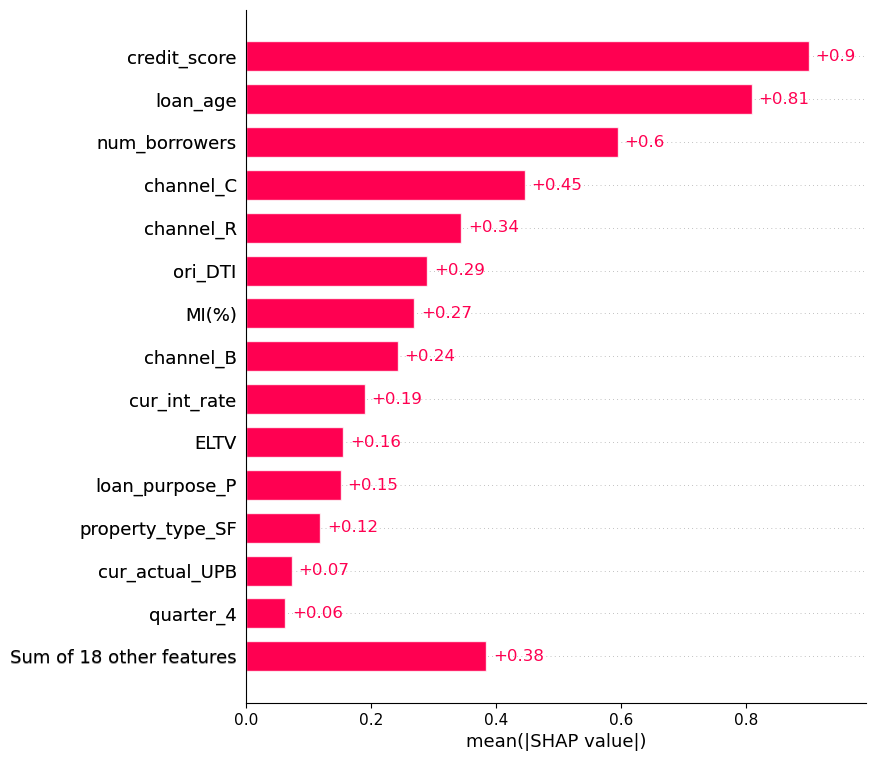


 Test Set


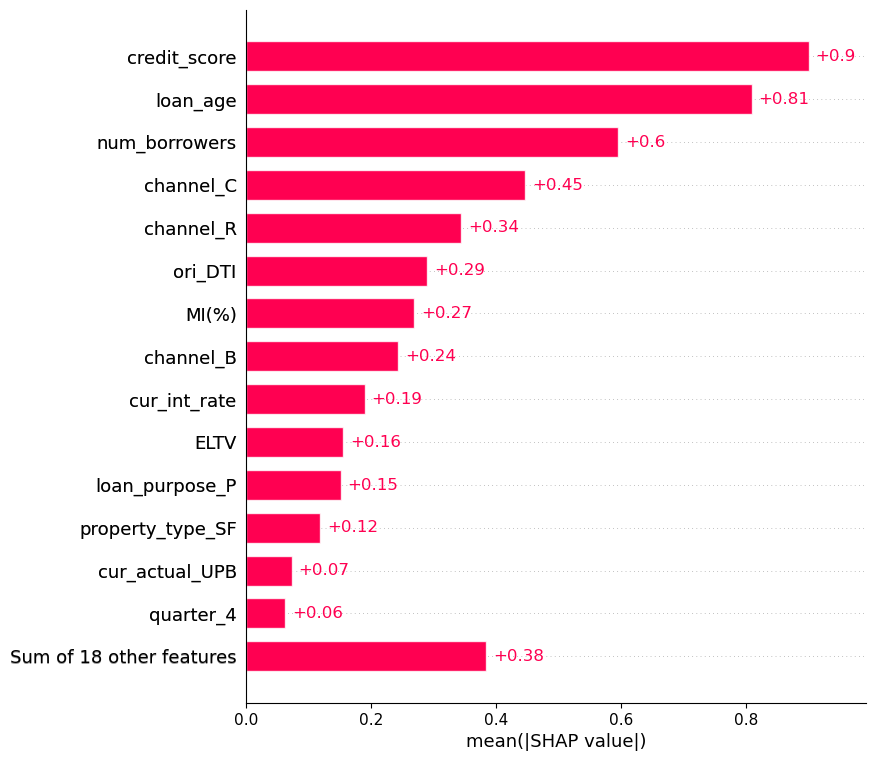


 Validation Set


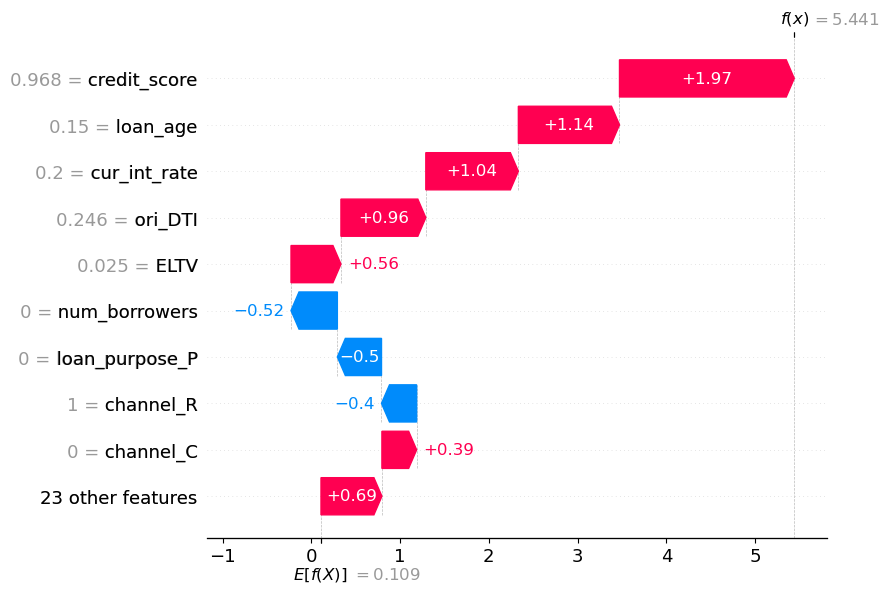


 Test Set


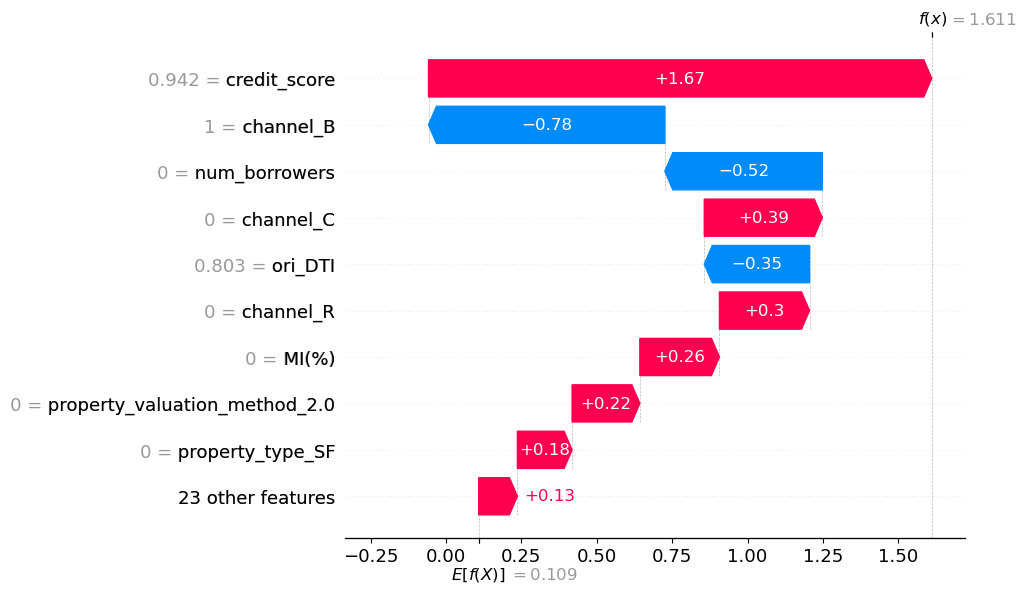

In [20]:
feature_importance_linear(logReg_best, X_resampled, X_val, X_test)


 Validation Set


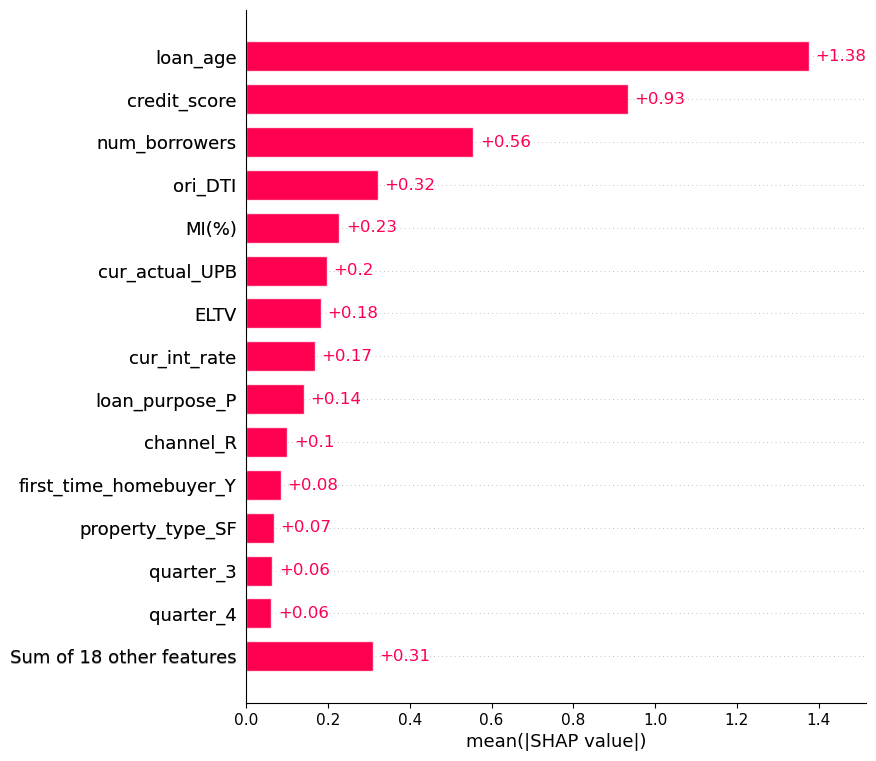


 Test Set


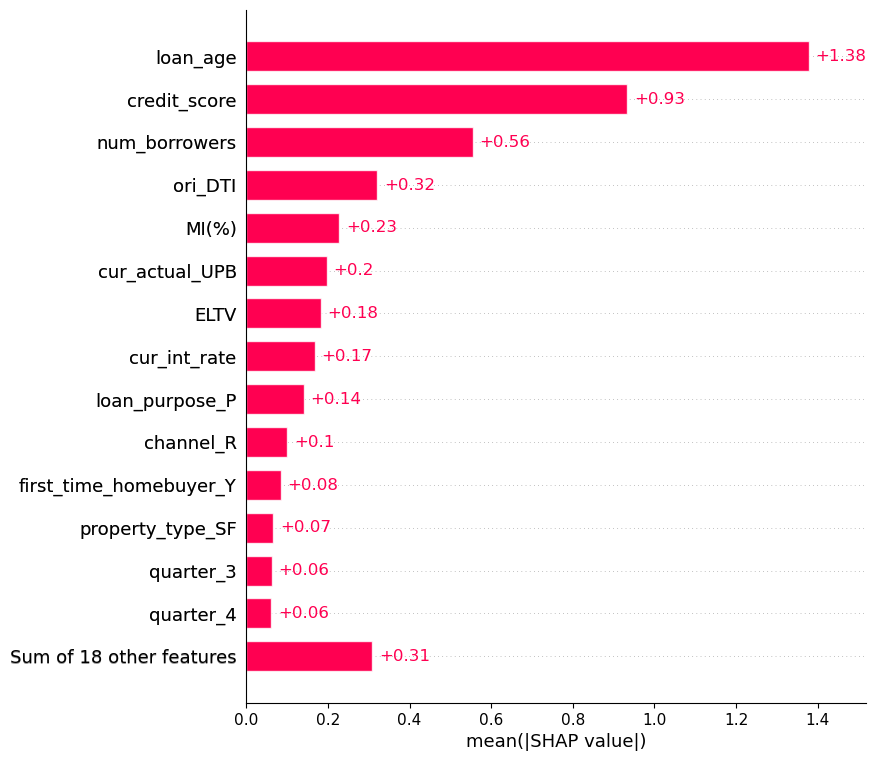


 Validation Set


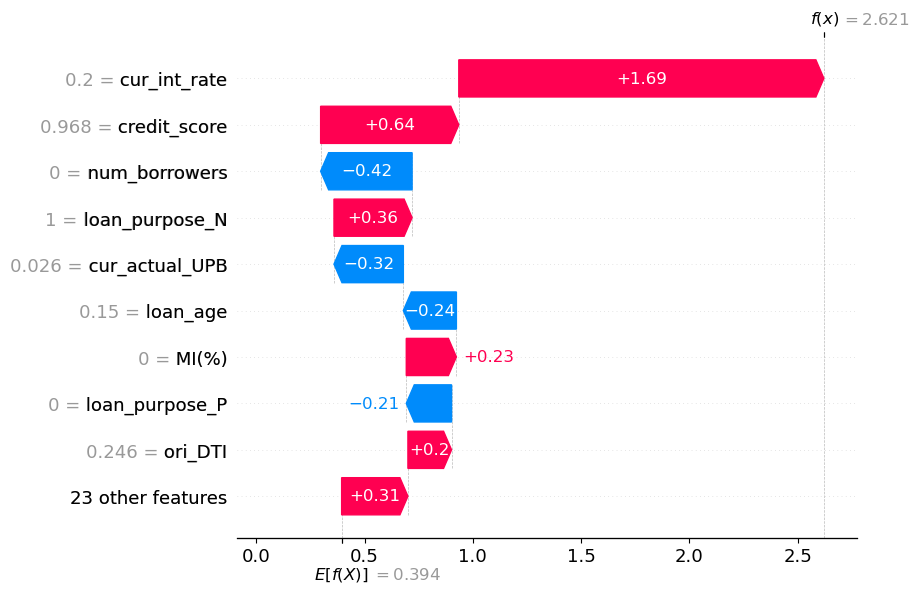


 Test Set


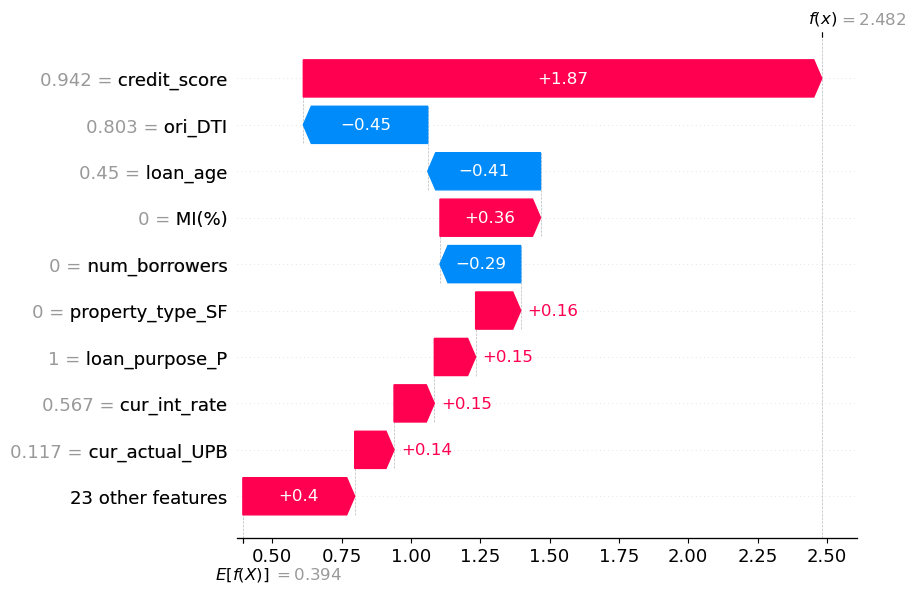

In [21]:
feature_importance_tree(lgb_model_best, X_val, X_test)


 Validation Set


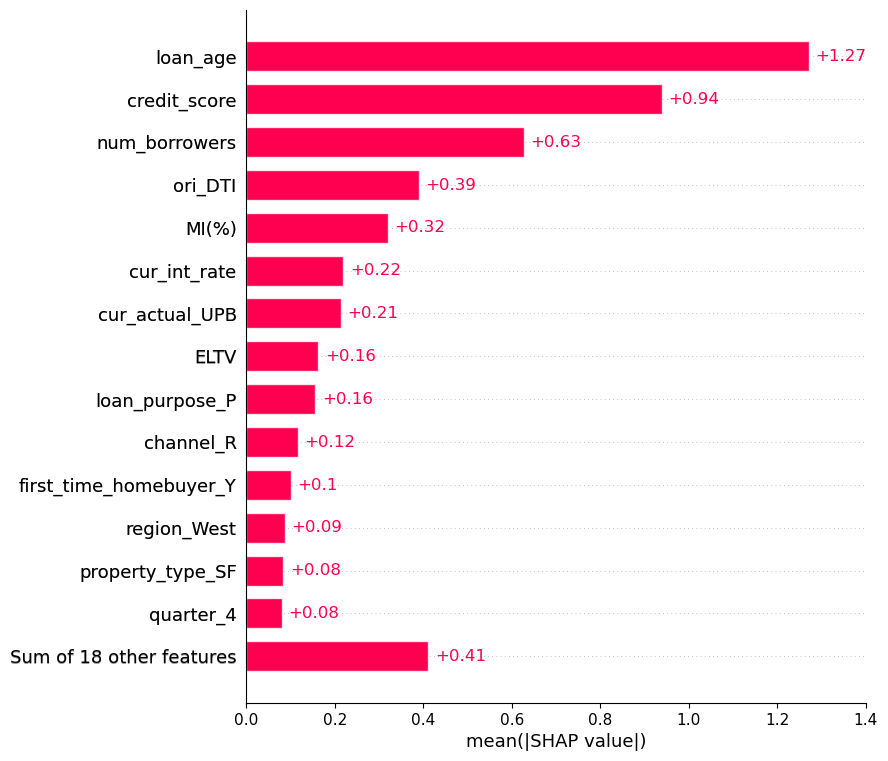


 Test Set


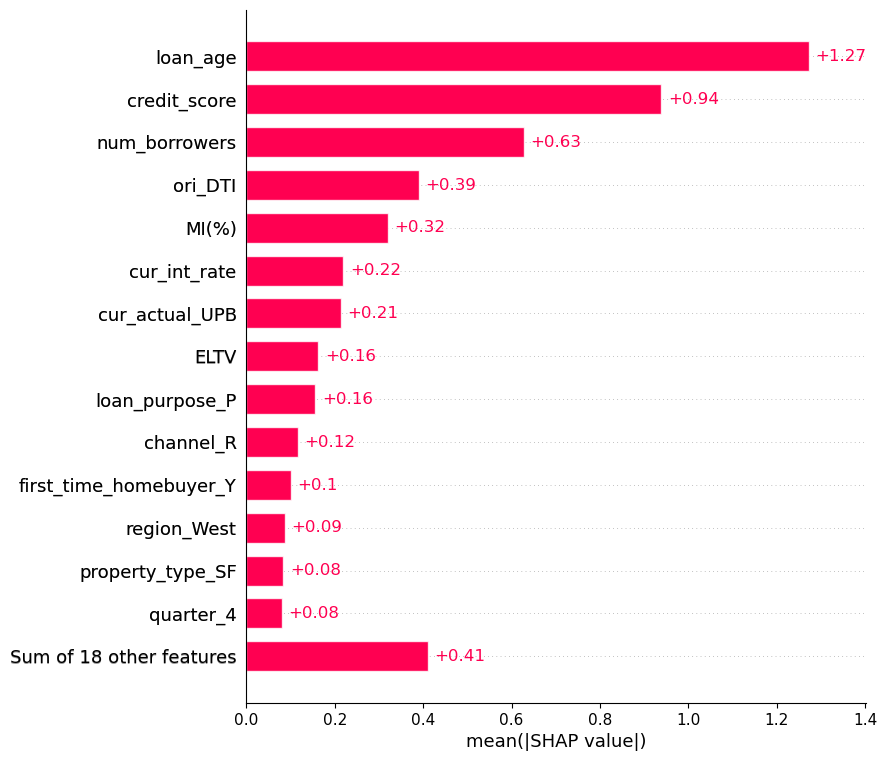


 Validation Set


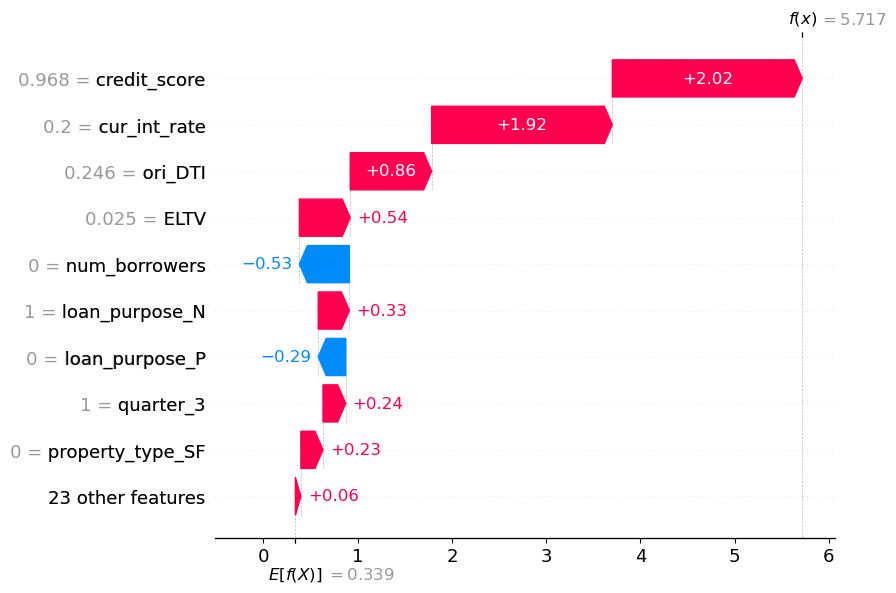


 Test Set


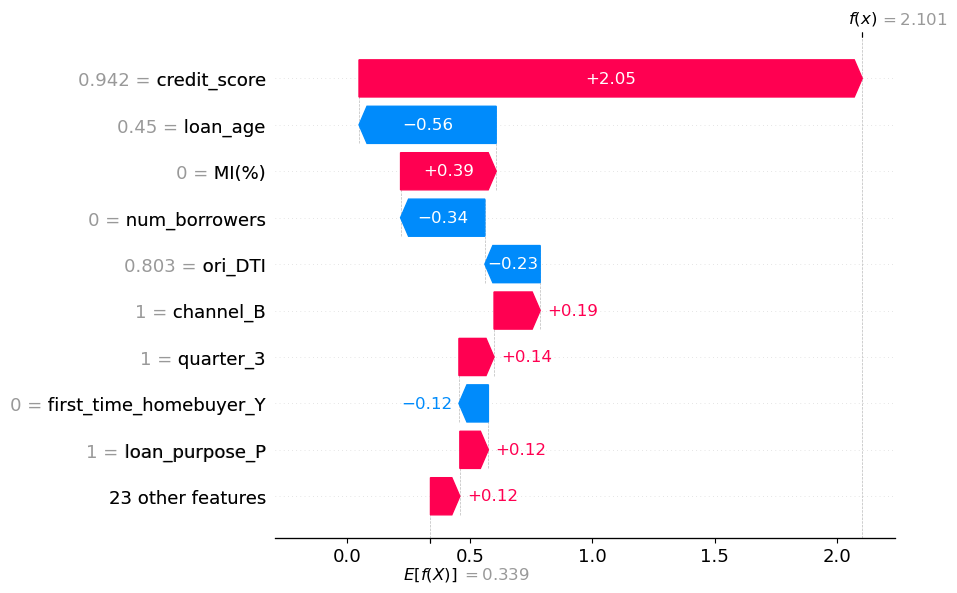

In [56]:
feature_importance_tree(cat_model_best, X_val, X_test)

---
## 6.0 Model Evaluation
Fairness of each models are evaluated based on demographic parity difference, equalized odds difference and disparate impact. F1-score, accuracy, G-mean, precision, and recall of the model are also evaluated. 

In [ ]:
logReg_best_pred_train = logReg_best.predict(X_resampled).flatten()
lgb_model_best_pred_train = lgb_model_best.predict(X_resampled).flatten()
cat_model_best_pred_train = cat_model_best.predict(X_resampled).flatten()

logReg_best_pred_val = logReg_best.predict(X_val).flatten()
lgb_model_best_pred_val = lgb_model_best.predict(X_val).flatten()
cat_model_best_pred_val = cat_model_best.predict(X_val).flatten()

logReg_best_pred = logReg_best.predict(X_test).flatten()
lgb_model_best_pred = lgb_model_best.predict(X_test).flatten()
cat_model_best_pred = cat_model_best.predict(X_test).flatten()

y_resampled = np.array(y_resampled).flatten()
y_val = np.array(y_val).flatten()
y_test = np.array(y_test).flatten()

logReg_best_pred_train = np.array(logReg_best_pred_train).flatten()
lgb_model_best_pred_train = np.array(lgb_model_best_pred_train).flatten()
cat_model_best_pred_train = np.array(cat_model_best_pred_train).flatten()

logReg_best_pred_val = np.array(logReg_best_pred_val).flatten()
lgb_model_best_pred_val = np.array(lgb_model_best_pred_val).flatten()
cat_model_best_pred_val = np.array(cat_model_best_pred_val).flatten()

logReg_best_pred = np.array(logReg_best_pred).flatten()
lgb_model_best_pred = np.array(lgb_model_best_pred).flatten()
cat_model_best_pred = np.array(cat_model_best_pred).flatten()

PROTECTED_ATTRIBUTES = ['region_Northeast', 'region_South', 'region_West','region_Other']

protected_attr = X_resampled[PROTECTED_ATTRIBUTES]
protected_attr_val = X_val[PROTECTED_ATTRIBUTES]
protected_attr_test = X_test[PROTECTED_ATTRIBUTES]

In [24]:
# Compute Disparate Impact 
def disparate_impact(y_pred, sensitive_feature):

    sensitive_feature = np.array(sensitive_feature).flatten()
    
    privileged_group = sensitive_feature == 1  
    unprivileged_group = sensitive_feature == 0  

    rate_privileged = np.mean(y_pred[privileged_group])
    rate_unprivileged = np.mean(y_pred[unprivileged_group])

    return rate_unprivileged / rate_privileged if rate_privileged > 0 else np.nan

# Calculate and print the fairness metrics
def fairness_metrics(y_true, y_pred, attr):
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=attr)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=attr)
    
    disparate_impact_scores = []
    protected_attr_array = np.array(attr)
    num_attributes = protected_attr_array.shape[1]
    for i in range(num_attributes):
        di = disparate_impact(y_pred, protected_attr_array[:, i])
        disparate_impact_scores.append(di)
    overall_disparate_impact = np.nanmean(disparate_impact_scores)

    print(f"Demographic Parity:  {dpd:.4f}")
    print(f"Equalized Odds: {eod:.4f}")
    print(f"Disparate Impact: {overall_disparate_impact:.4f}")

### 6.1 Logistic Regression

In [25]:
for dataset, y_true, pred, protected in [
    ("Train", y_resampled, logReg_best_pred_train, protected_attr),
    ("Validation", y_val, logReg_best_pred_val, protected_attr_val),
    ("Test", y_test, logReg_best_pred, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - Logistic Regression ===")
    fairness_metrics(y_true, pred, protected)
    
print_result(logReg_best,X_resampled, X_val, X_test)



=== Fairness Evaluation: Train Set - Logistic Regression ===
Demographic Parity:  0.4308
Equalized Odds: 0.3213
Disparate Impact: 0.8718

=== Fairness Evaluation: Validation Set - Logistic Regression ===
Demographic Parity:  0.1077
Equalized Odds: 0.2260
Disparate Impact: 0.9704

=== Fairness Evaluation: Test Set - Logistic Regression ===
Demographic Parity:  0.0842
Equalized Odds: 0.2174
Disparate Impact: 0.9773
Classification report of train set
               precision    recall  f1-score   support

       False       0.78      0.81      0.79     25843
        True       0.80      0.77      0.78     25843

    accuracy                           0.79     51686
   macro avg       0.79      0.79      0.79     51686
weighted avg       0.79      0.79      0.79     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.81      0.02      8736
        True       1.00      0.76      0.86   2587089

    accuracy  

### 6.2 LightGBM

In [26]:
for dataset, y_true, pred, protected in [
    ("Train", y_resampled, lgb_model_best_pred_train, protected_attr),
    ("Validation", y_val, lgb_model_best_pred_val, protected_attr_val),
    ("Test", y_test, lgb_model_best_pred, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - LightGBM ===")
    fairness_metrics(y_true, pred, protected)
    
print_result(lgb_model_best,X_resampled, X_val, X_test) 


=== Fairness Evaluation: Train Set - LightGBM ===
Demographic Parity:  0.4477
Equalized Odds: 0.3912
Disparate Impact: 0.8652

=== Fairness Evaluation: Validation Set - LightGBM ===
Demographic Parity:  0.0264
Equalized Odds: 0.1860
Disparate Impact: 0.9956

=== Fairness Evaluation: Test Set - LightGBM ===
Demographic Parity:  0.0504
Equalized Odds: 0.1769
Disparate Impact: 1.0076
Classification report of train set
               precision    recall  f1-score   support

       False       0.82      0.88      0.85     25843
        True       0.87      0.81      0.84     25843

    accuracy                           0.85     51686
   macro avg       0.85      0.85      0.85     51686
weighted avg       0.85      0.85      0.85     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.86      0.03      8736
        True       1.00      0.78      0.88   2587089

    accuracy                           0.78   2

### 6.3 CatBoost

In [57]:
for dataset, y_true, pred, protected in [
    ("Train", y_resampled, cat_model_best_pred_train, protected_attr),
    ("Validation", y_val, cat_model_best_pred_val, protected_attr_val),
    ("Test", y_test, cat_model_best_pred, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - CatBoost ===")
    fairness_metrics(y_true, pred, protected)
    
print_result(cat_model_best,X_resampled, X_val, X_test)


=== Fairness Evaluation: Train Set - CatBoost ===
Demographic Parity:  0.3285
Equalized Odds: 0.1913
Disparate Impact: 0.8880

=== Fairness Evaluation: Validation Set - CatBoost ===
Demographic Parity:  0.0749
Equalized Odds: 0.1666
Disparate Impact: 0.9759

=== Fairness Evaluation: Test Set - CatBoost ===
Demographic Parity:  0.0468
Equalized Odds: 0.1662
Disparate Impact: 0.9840
Classification report of train set
               precision    recall  f1-score   support

       False       0.83      0.88      0.86     25843
        True       0.88      0.82      0.85     25843

    accuracy                           0.85     51686
   macro avg       0.85      0.85      0.85     51686
weighted avg       0.85      0.85      0.85     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.86      0.03      8736
        True       1.00      0.79      0.88   2587089

    accuracy                           0.79   2

---
## 7.0 Fairness Pre-processing 
By using fairness pre-processing algorithm, model interpretation and model evaluation are conducted and evaluated. 

In [28]:
# Apply Correlation Remover
def apply_cor_remover(attr, X_true):
    corr_remover = CorrelationRemover(sensitive_feature_ids=attr, alpha=0.05)
    X_true_transformed = corr_remover.fit_transform(X_true)
    return X_true_transformed
X_resampled_transformed = apply_cor_remover(protected_attr, X_resampled)
X_transformed_val = apply_cor_remover(protected_attr_val, X_val)
X_transformed_test = apply_cor_remover(protected_attr_test, X_test)

### 7.1 Logistic Regression

In [29]:
logReg_reweighed = LogisticRegression(**best_params_lr)
logReg_reweighed.fit(X_resampled_transformed, y_resampled)

logReg_reweighed_pred_train = logReg_reweighed.predict(X_resampled_transformed).flatten()
logReg_reweighed_pred_val = logReg_reweighed.predict(X_transformed_val).flatten()
logReg_reweighed_pred = logReg_reweighed.predict(X_transformed_test).flatten()

LinearExplainer explainer: 2595826it [00:22, 59435.75it/s]                              
LinearExplainer explainer: 2595826it [00:21, 57337.34it/s]                              



 Validation Set


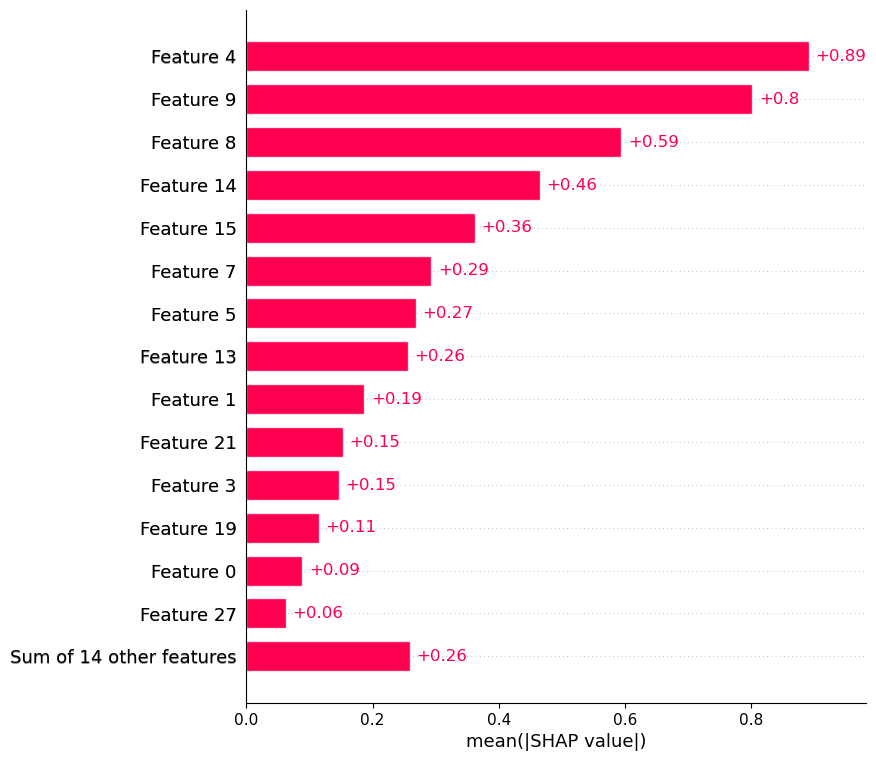


 Test Set


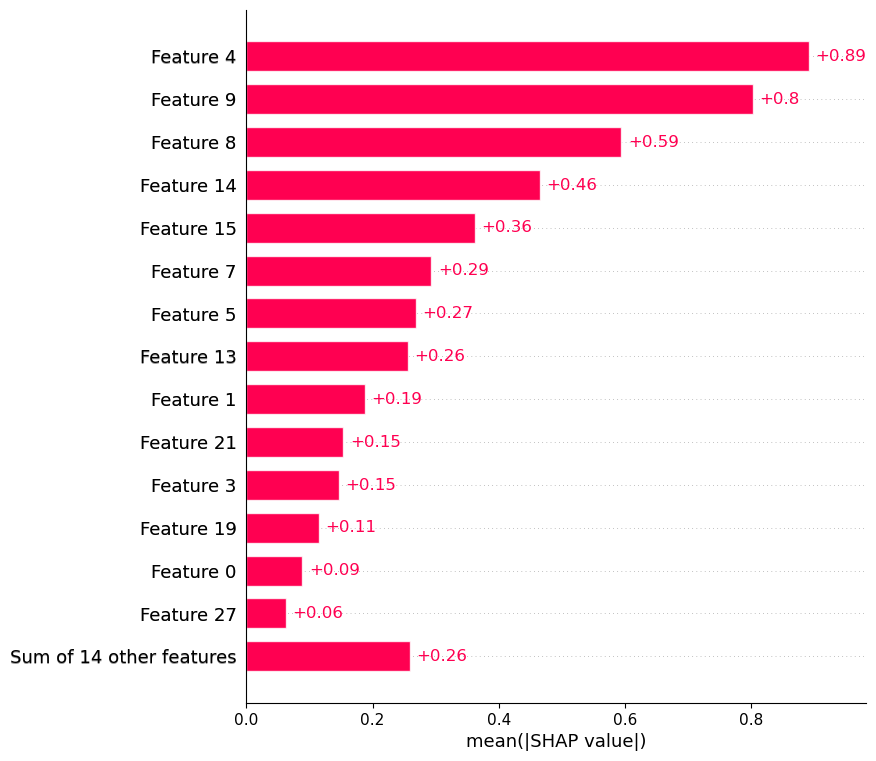


 Validation Set


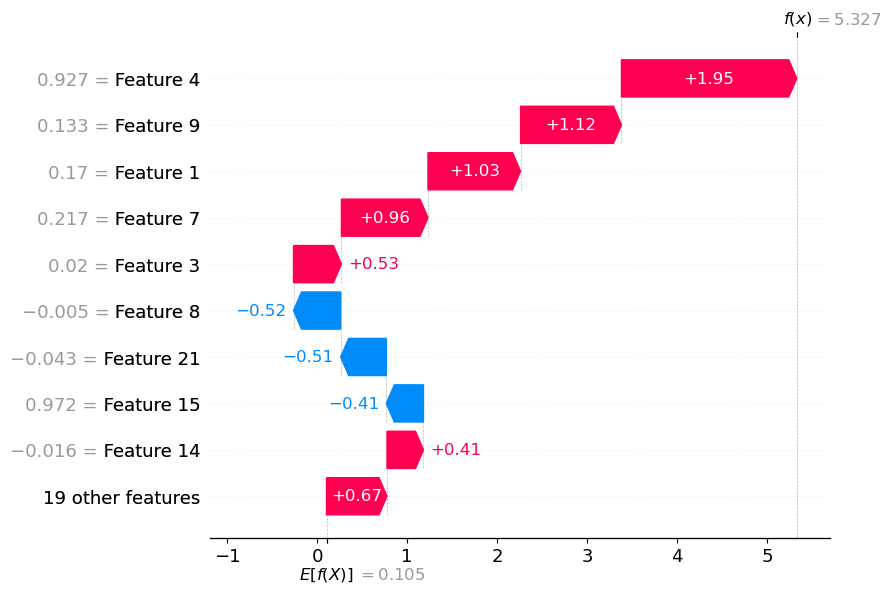


 Test Set


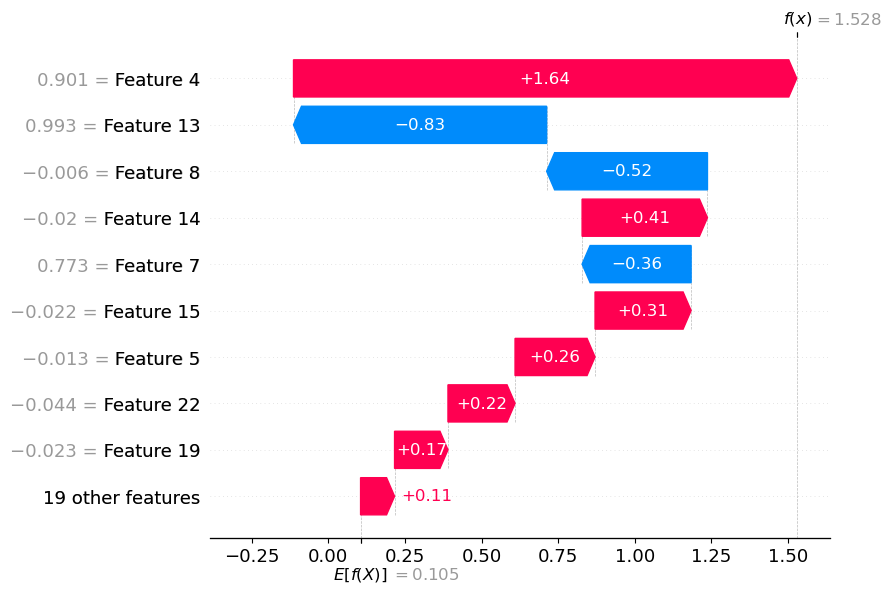

In [30]:
feature_importance_linear(logReg_reweighed, X_resampled_transformed, X_transformed_val, X_transformed_test)

In [31]:

for dataset, y_true, pred, protected in [
    ("Train", y_resampled, logReg_reweighed_pred_train, protected_attr),
    ("Validation", y_val, logReg_reweighed_pred_val, protected_attr_val),
    ("Test", y_test, logReg_reweighed_pred, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - Logistic Regression ===")
    fairness_metrics(y_true, pred, protected)

print_result(logReg_reweighed, X_resampled_transformed, X_transformed_val, X_transformed_test)


=== Fairness Evaluation: Train Set - Logistic Regression ===
Demographic Parity:  0.4394
Equalized Odds: 0.3302
Disparate Impact: 0.8616

=== Fairness Evaluation: Validation Set - Logistic Regression ===
Demographic Parity:  0.1772
Equalized Odds: 0.8460
Disparate Impact: 0.9462

=== Fairness Evaluation: Test Set - Logistic Regression ===
Demographic Parity:  0.1546
Equalized Odds: 0.2214
Disparate Impact: 0.9517
Classification report of train set
               precision    recall  f1-score   support

       False       0.78      0.81      0.79     25843
        True       0.80      0.77      0.78     25843

    accuracy                           0.79     51686
   macro avg       0.79      0.79      0.79     51686
weighted avg       0.79      0.79      0.79     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.82      0.02      8736
        True       1.00      0.75      0.86   2587089

    accuracy  

### 7.2 LightGBM

In [32]:
lgb_reweighed = lgb.LGBMClassifier(**best_params_lgb)
lgb_reweighed.fit(X_resampled_transformed, y_resampled)

lgb_reweighed_pred_train = lgb_reweighed.predict(X_resampled_transformed).flatten()
lgb_reweighed_pred_val = lgb_reweighed.predict(X_transformed_val).flatten()
lgb_reweighed_pred = lgb_reweighed.predict(X_transformed_test).flatten()

c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 Validation Set


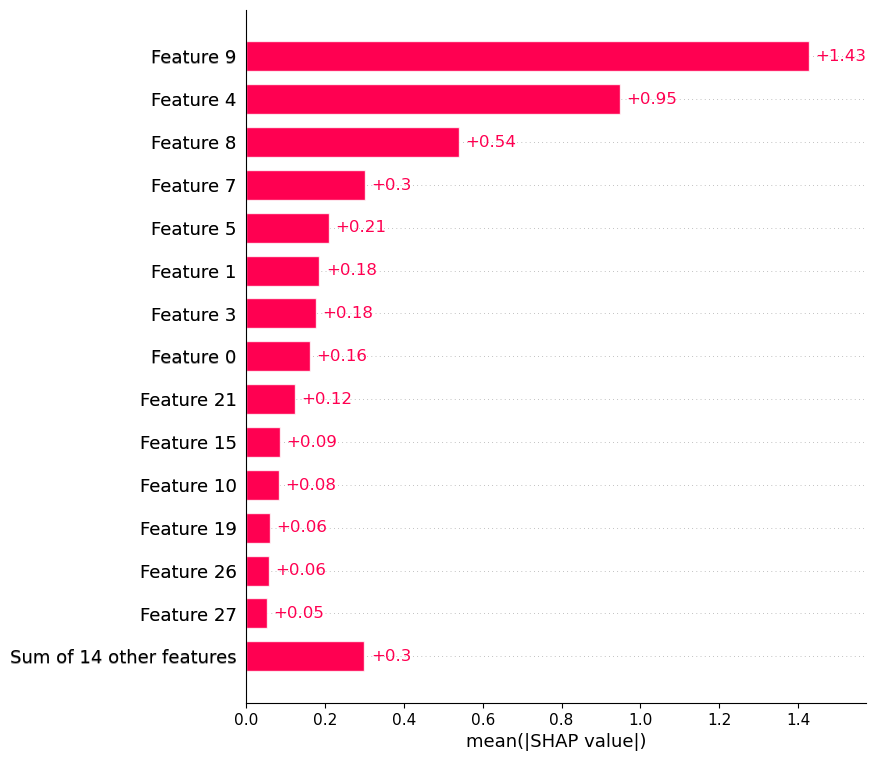


 Test Set


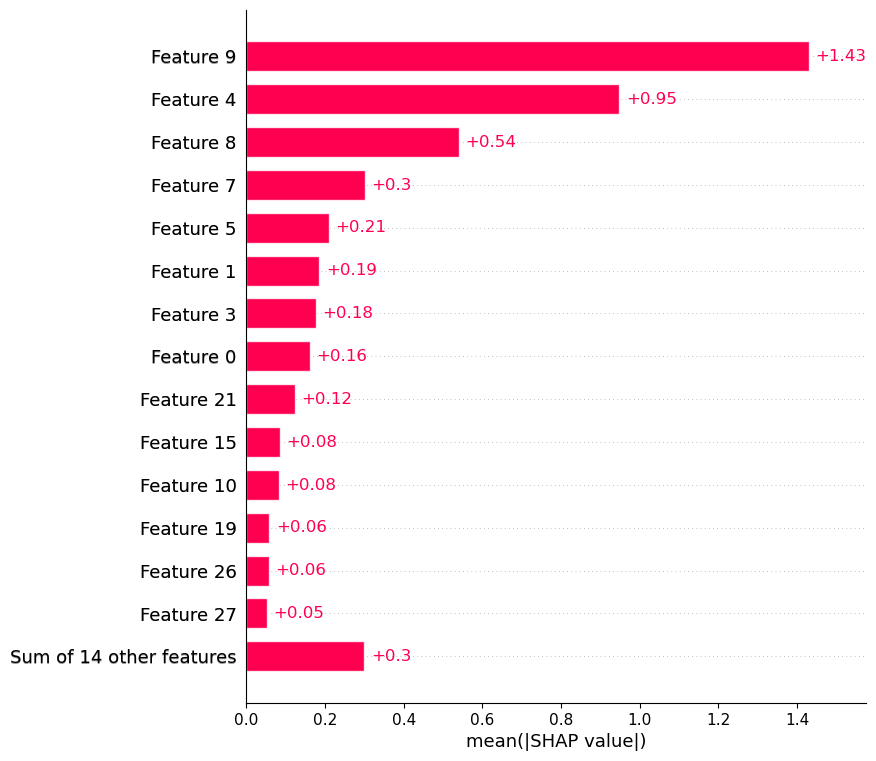


 Validation Set


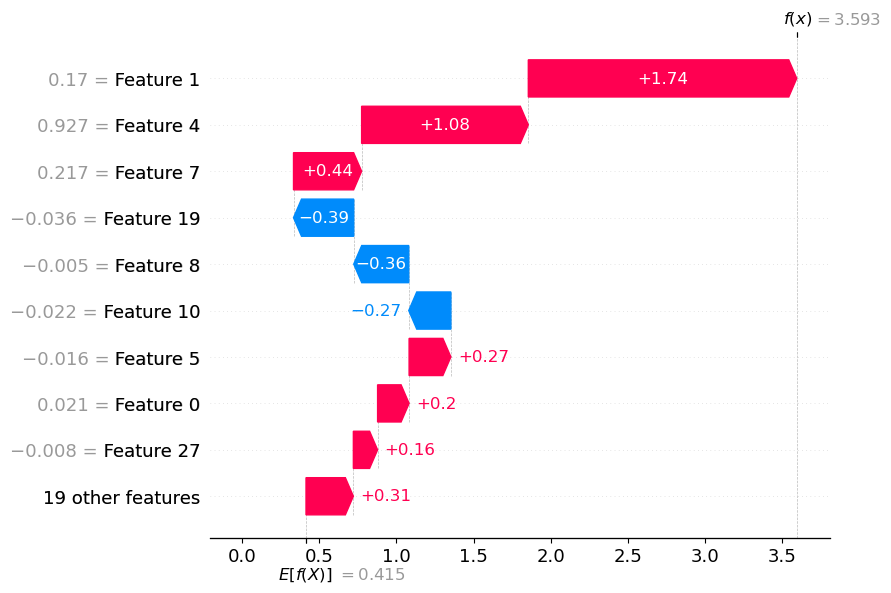


 Test Set


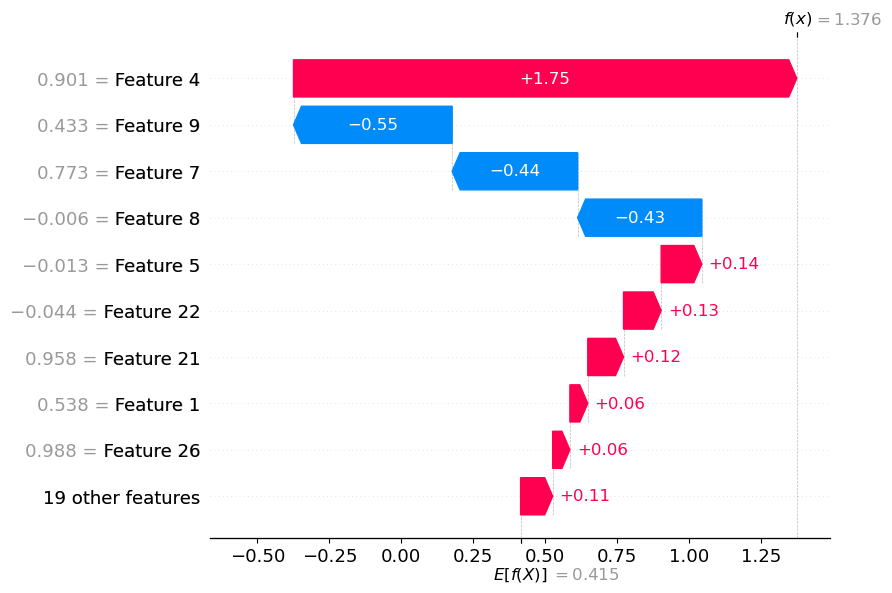

In [33]:
feature_importance_tree(lgb_reweighed, X_transformed_val, X_transformed_test)

In [34]:
for dataset, y_true, pred, protected in [
    ("Train", y_resampled, lgb_reweighed_pred_train, protected_attr),
    ("Validation", y_val, lgb_reweighed_pred_val, protected_attr_val),
    ("Test", y_test, lgb_reweighed_pred, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - LightGBM ===")
    fairness_metrics(y_true, pred, protected)

print_result(lgb_reweighed, X_resampled_transformed, X_transformed_val, X_transformed_test)


=== Fairness Evaluation: Train Set - LightGBM ===
Demographic Parity:  0.5529
Equalized Odds: 0.8990
Disparate Impact: 0.8557

=== Fairness Evaluation: Validation Set - LightGBM ===
Demographic Parity:  0.1896
Equalized Odds: 0.9020
Disparate Impact: 0.9436

=== Fairness Evaluation: Test Set - LightGBM ===
Demographic Parity:  0.1339
Equalized Odds: 0.1602
Disparate Impact: 0.9570


c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\a

Classification report of train set
               precision    recall  f1-score   support

       False       0.83      0.88      0.85     25843
        True       0.87      0.81      0.84     25843

    accuracy                           0.85     51686
   macro avg       0.85      0.85      0.85     51686
weighted avg       0.85      0.85      0.85     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.88      0.02      8736
        True       1.00      0.73      0.85   2587089

    accuracy                           0.73   2595825
   macro avg       0.51      0.81      0.43   2595825
weighted avg       1.00      0.73      0.84   2595825

Classification report of test set
               precision    recall  f1-score   support

       False       0.01      0.87      0.02      8773
        True       1.00      0.73      0.85   2587052

    accuracy                           0.74   2595825
   macro avg    

### 7.3 CatBoost

In [58]:
cat_reweighed = CatBoostClassifier(**best_params_cat, iterations=200)
cat_reweighed.fit(X_resampled_transformed, y_resampled,plot=True)

cat_reweighed_pred_train = cat_reweighed.predict(X_resampled_transformed).flatten()
cat_reweighed_pred_val = cat_reweighed.predict(X_transformed_val).flatten()
cat_reweighed_pred = cat_reweighed.predict(X_transformed_test).flatten()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5882861	total: 27.8ms	remaining: 5.53s
1:	learn: 0.5304495	total: 48.1ms	remaining: 4.76s
2:	learn: 0.4941064	total: 62.2ms	remaining: 4.08s
3:	learn: 0.4784279	total: 77.2ms	remaining: 3.78s
4:	learn: 0.4692730	total: 93.6ms	remaining: 3.65s
5:	learn: 0.4634743	total: 108ms	remaining: 3.49s
6:	learn: 0.4593874	total: 119ms	remaining: 3.27s
7:	learn: 0.4560435	total: 136ms	remaining: 3.26s
8:	learn: 0.4532531	total: 152ms	remaining: 3.22s
9:	learn: 0.4502197	total: 167ms	remaining: 3.17s
10:	learn: 0.4481968	total: 180ms	remaining: 3.09s
11:	learn: 0.4462729	total: 195ms	remaining: 3.05s
12:	learn: 0.4442036	total: 211ms	remaining: 3.04s
13:	learn: 0.4427950	total: 227ms	remaining: 3.01s
14:	learn: 0.4416001	total: 242ms	remaining: 2.99s
15:	learn: 0.4388899	total: 256ms	remaining: 2.95s
16:	learn: 0.4376696	total: 268ms	remaining: 2.88s
17:	learn: 0.4366225	total: 283ms	remaining: 2.86s
18:	learn: 0.4356257	total: 294ms	remaining: 2.8s
19:	learn: 0.4349927	total: 309ms	rem


 Validation Set


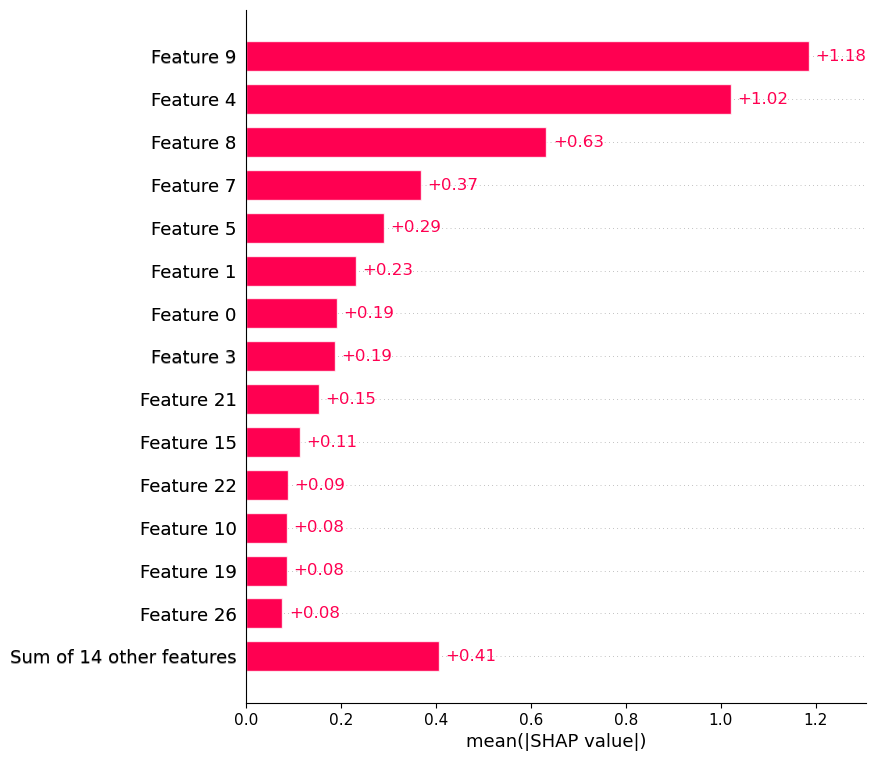


 Test Set


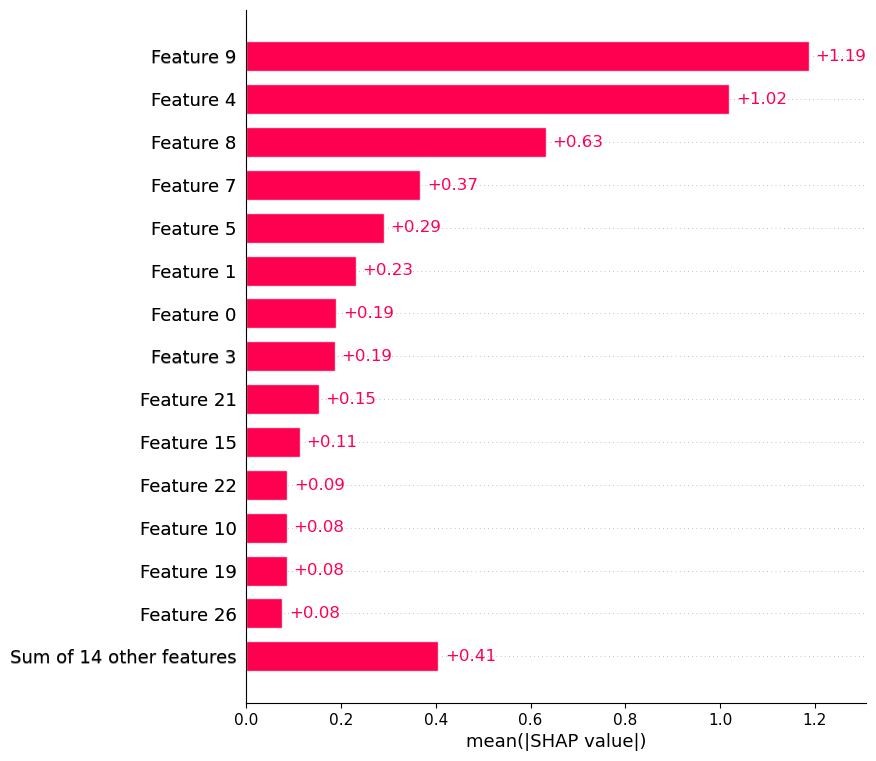


 Validation Set


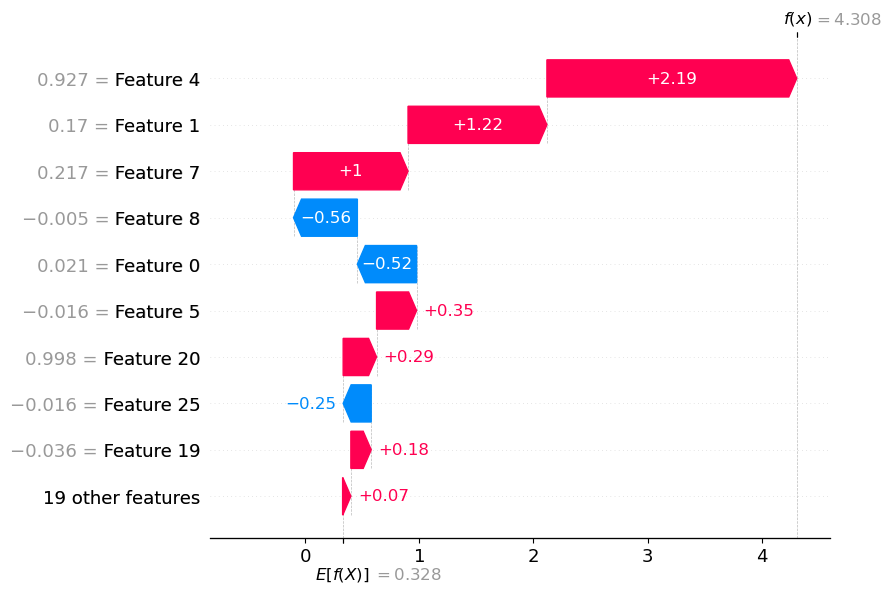


 Test Set


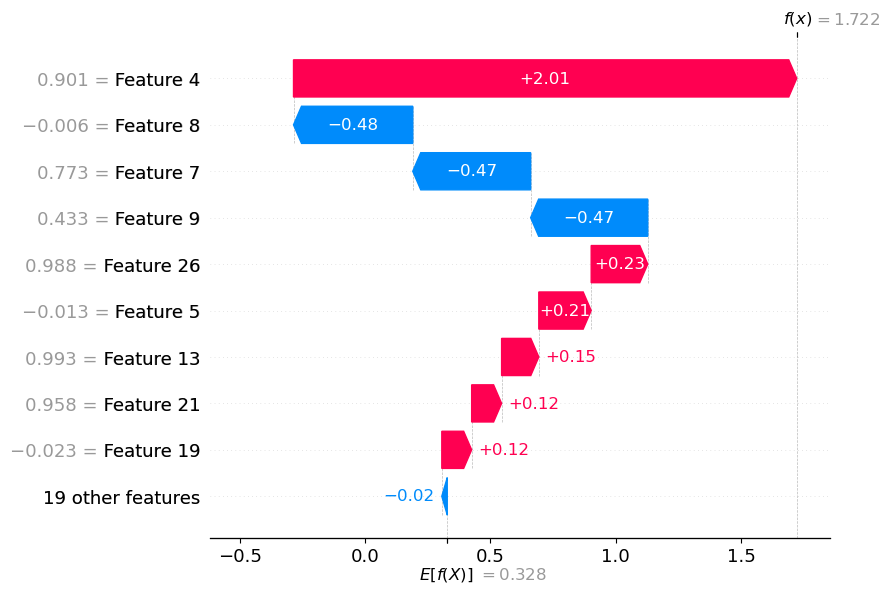

In [59]:
feature_importance_tree(cat_reweighed, X_transformed_val, X_transformed_test)

In [60]:
for dataset, y_true, pred, protected in [
    ("Train", y_resampled, cat_reweighed_pred_train, protected_attr),
    ("Validation", y_val, cat_reweighed_pred_val, protected_attr_val),
    ("Test", y_test, cat_reweighed_pred, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - CatBoost ===")
    fairness_metrics(y_true, pred, protected)

print_result(cat_reweighed, X_resampled_transformed, X_transformed_val, X_transformed_test)


=== Fairness Evaluation: Train Set - CatBoost ===
Demographic Parity:  0.3262
Equalized Odds: 0.1807
Disparate Impact: 0.8906

=== Fairness Evaluation: Validation Set - CatBoost ===
Demographic Parity:  0.1862
Equalized Odds: 0.8716
Disparate Impact: 0.9491

=== Fairness Evaluation: Test Set - CatBoost ===
Demographic Parity:  0.1417
Equalized Odds: 0.1789
Disparate Impact: 0.9596
Classification report of train set
               precision    recall  f1-score   support

       False       0.84      0.89      0.86     25843
        True       0.88      0.83      0.85     25843

    accuracy                           0.86     51686
   macro avg       0.86      0.86      0.86     51686
weighted avg       0.86      0.86      0.86     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.85      0.02      8736
        True       1.00      0.76      0.86   2587089

    accuracy                           0.76   2

---
## 8.0 Fairness In-processing
By using fairness in-processing algorithm, model interpretation and model evaluation are conducted and evaluated. 
### 8.1 Logistic Regression

In [38]:
def get_best_predictor(model):
    # Get all predictors
    predictors = list(model.predictors_)
    
    # Get accuracy scores for each predictor
    scores = []
    for predictor in predictors:
        y_pred = predictor.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        scores.append(score)
    
    # Find index of best predictor
    best_idx = np.argmax(scores)
    
    return predictors[best_idx]

def print_result2(model, X_sample, X_sample_val, X_sample_test):
    train_pred = model.predict(X_sample)
    val_pred = model.predict(X_sample_val)
    y_pred = model.predict(X_sample_test)

    # Confusion Matrix
    conf_matrix_val = confusion_matrix(y_val, val_pred)
    conf_matrix_test = confusion_matrix(y_test, y_pred)
    conf_matrix_train = confusion_matrix(y_resampled, train_pred)

    # Accuracy
    train_acc = accuracy_score(y_resampled, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, y_pred)

    final_model = get_best_predictor(model) 

    # Predictions
    train_pred_proba = final_model.predict_proba(X_sample)[:, 1]
    val_pred_proba = final_model.predict_proba(X_sample_val)[:, 1]
    test_pred_proba = final_model.predict_proba(X_sample_test)[:, 1]

    # Precision
    train_precision = precision_score(y_resampled, train_pred)
    val_precision = precision_score(y_val, val_pred)
    test_precision = precision_score(y_test, y_pred)

    # Recall
    train_recall = recall_score(y_resampled, train_pred)
    val_recall = recall_score(y_val, val_pred)
    test_recall = recall_score(y_test, y_pred)

    # F1 Score
    train_f1 = f1_score(y_resampled, train_pred)
    val_f1 = f1_score(y_val, val_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    # ROC AUC Score
    val_auc = roc_auc_score(y_val, val_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    train_auc = roc_auc_score(y_resampled, train_pred_proba)

    # G-Mean
    val_gmean = geometric_mean_score(y_val, val_pred)
    test_gmean = geometric_mean_score(y_test, y_pred)
    train_gmean = geometric_mean_score(y_resampled, train_pred)

    TN_train, FP_train= conf_matrix_train[0][0], conf_matrix_train[0][1]
    TN_val, FP_val= conf_matrix_val[0][0], conf_matrix_val[0][1]
    TN_test, FP_test= conf_matrix_test[0][0], conf_matrix_test[0][1]
    
    # Specificity
    specificity_train = TN_train / (TN_train + FP_train)
    specificity_val = TN_val / (TN_val + FP_val)
    specificity_test = TN_test / (TN_test + FP_test)

    print("Classification report of train set\n", classification_report (y_resampled, train_pred))
    print("Classification report of validation set\n",classification_report (y_val, val_pred))
    print("Classification report of test set\n", classification_report (y_test, y_pred))

    print(f"\nTrain Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    print(f"\nTrain Specificity: {specificity_train:.4f}")
    print(f"Validation Specificity: {specificity_val:.4f}")
    print(f"Test Specificity: {specificity_test:.4f}")

    print(f"\nTrain Precision: {train_precision:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Test Precision: {test_precision:.4f}")

    print(f"\nTrain Recall: {train_recall:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    print(f"\nTrain F1 Score: {train_f1:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    print(f"\nTrain AUC: {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    print("\nConfusion Matrix of train set:\n", conf_matrix_train)
    print("\nConfusion Matrix of validation set:\n", conf_matrix_val)
    print("\nConfusion Matrix of test set:\n", conf_matrix_test)

    print(f'\nGeometric Mean (G-Mean) of train set: {val_gmean:.4f}')
    print(f'Geometric Mean (G-Mean) of validation set: {test_gmean:.4f}')
    print(f'Geometric Mean (G-Mean) of test set: {train_gmean:.4f}')
    

In [39]:
fair_logReg = ExponentiatedGradient(
    logReg_best,
    constraints=EqualizedOdds()
)

fair_logReg.fit(X_resampled, y_resampled, sensitive_features=protected_attr)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x000002BE215F1650>,
                      estimator=LogisticRegression(C=9.044635025277646,
                                                   max_iter=1000,
                                                   solver='liblinear'),
                      nu=0.0008996211272030104)

LinearExplainer explainer: 2595826it [00:21, 59220.53it/s]                              
LinearExplainer explainer: 2595826it [00:21, 59804.47it/s]                              



 Validation Set


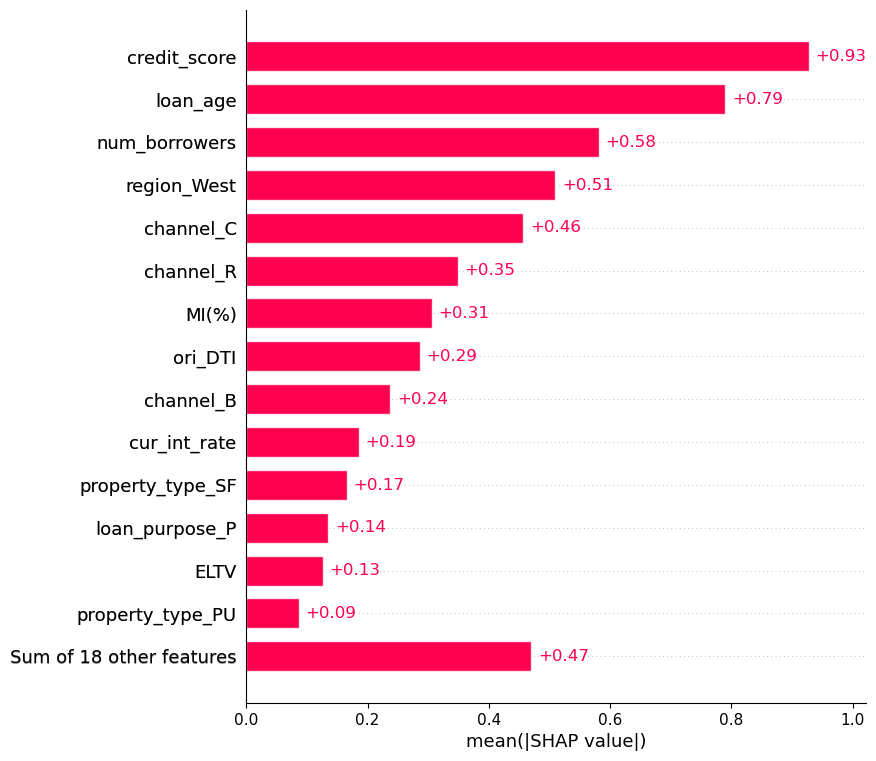


 Test Set


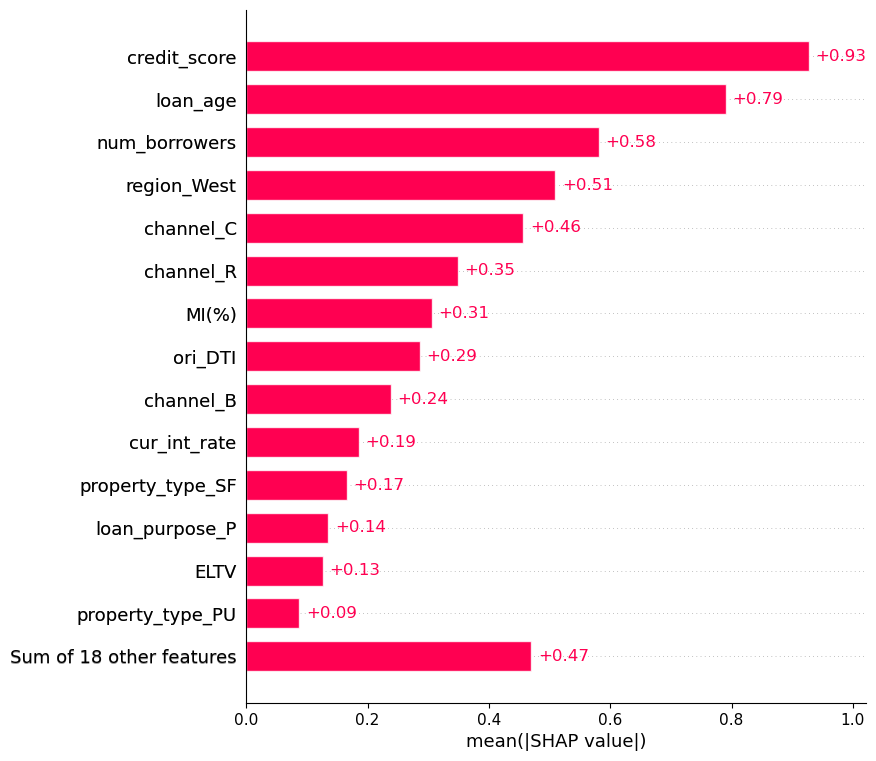


 Validation Set


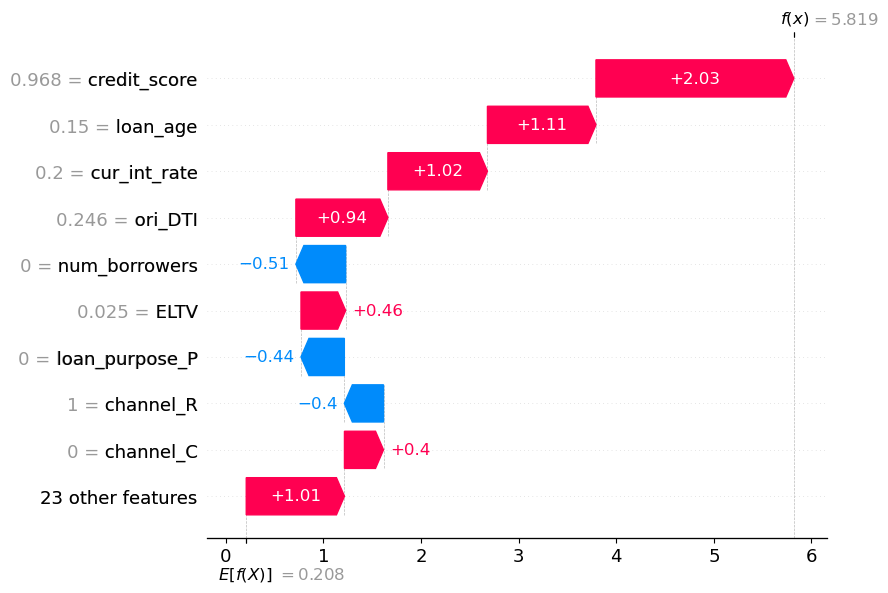


 Test Set


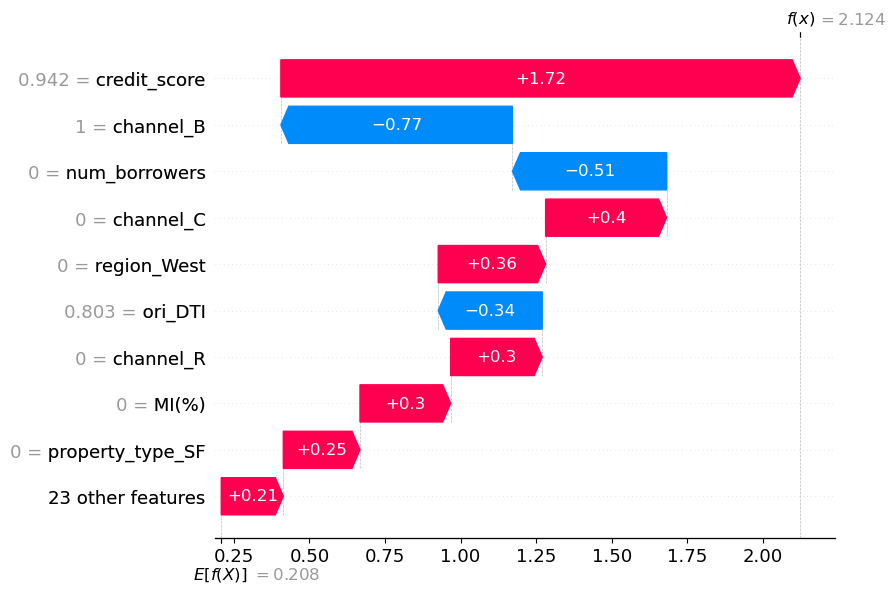

In [40]:
feature_importance_linear_in_processing(fair_logReg, X_resampled)

In [41]:
logReg_pred_fair_train = fair_logReg.predict(X_resampled).flatten()
logReg_pred_fair_val = fair_logReg.predict(X_val).flatten()
logReg_pred_fair = fair_logReg.predict(X_test).flatten()

for dataset, y_true, pred, protected in [
    ("Train", y_resampled, logReg_pred_fair_train, protected_attr),
    ("Validation", y_val, logReg_pred_fair_val, protected_attr_val),
    ("Test", y_test, logReg_pred_fair, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - Logistic Regression ===")
    fairness_metrics(y_true, pred, protected)

print_result2(fair_logReg, X_resampled, X_val, X_test)


=== Fairness Evaluation: Train Set - Logistic Regression ===
Demographic Parity:  0.0898
Equalized Odds: 0.3129
Disparate Impact: 0.9566

=== Fairness Evaluation: Validation Set - Logistic Regression ===
Demographic Parity:  0.1671
Equalized Odds: 0.2198
Disparate Impact: 1.0694

=== Fairness Evaluation: Test Set - Logistic Regression ===
Demographic Parity:  0.2239
Equalized Odds: 0.2256
Disparate Impact: 1.1038
Classification report of train set
               precision    recall  f1-score   support

       False       0.78      0.81      0.79     25843
        True       0.80      0.77      0.78     25843

    accuracy                           0.79     51686
   macro avg       0.79      0.79      0.79     51686
weighted avg       0.79      0.79      0.79     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.81      0.02      8736
        True       1.00      0.76      0.87   2587089

    accuracy  

### 8.2 LightGBM

In [42]:
fair_lgb = ExponentiatedGradient(
    lgb_model_best,
    constraints=EqualizedOdds()
)

fair_lgb.fit(X_resampled, y_resampled, sensitive_features=protected_attr)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x000002BC614551D0>,
                      estimator=LGBMClassifier(bagging_fraction=0.711726939754358,
                                               bagging_freq=8,
                                               learning_rate=0.21736680731470062,
                                               max_depth=7),
                      nu=0.000794669961785795)


 Validation Set


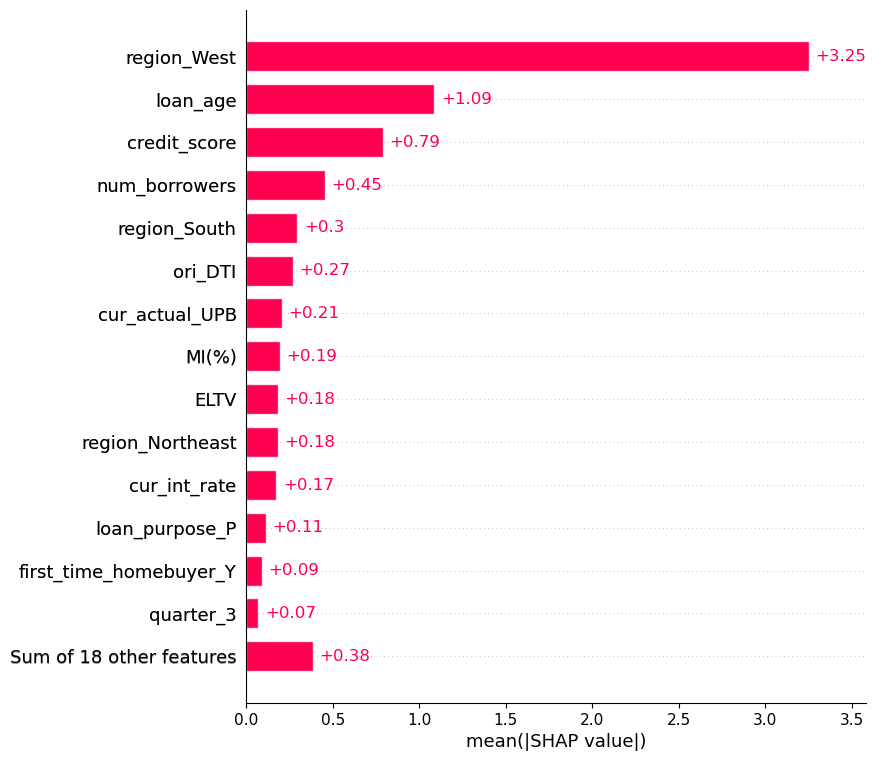


 Test Set


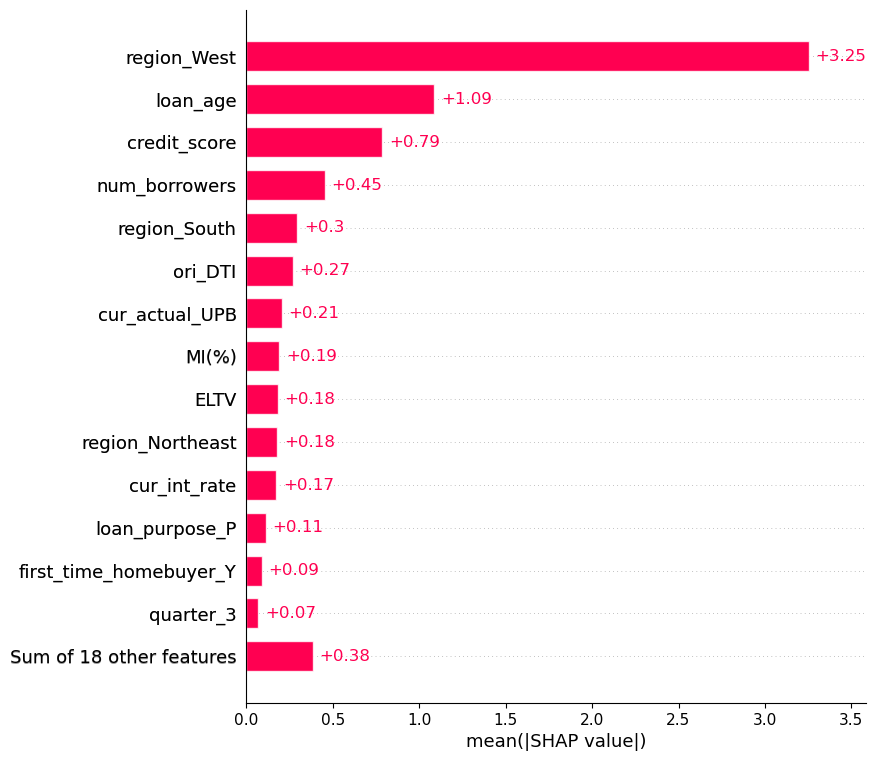


 Validation Set


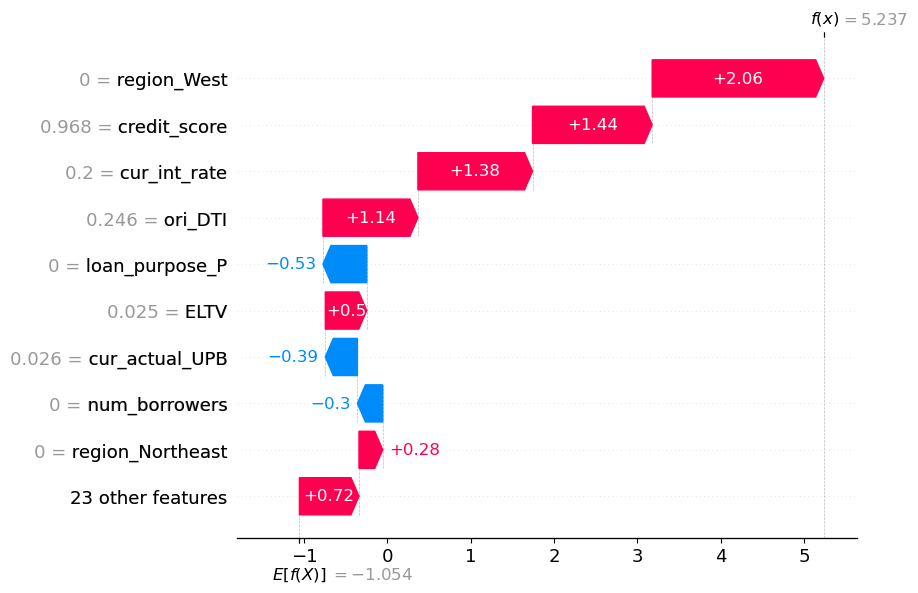


 Test Set


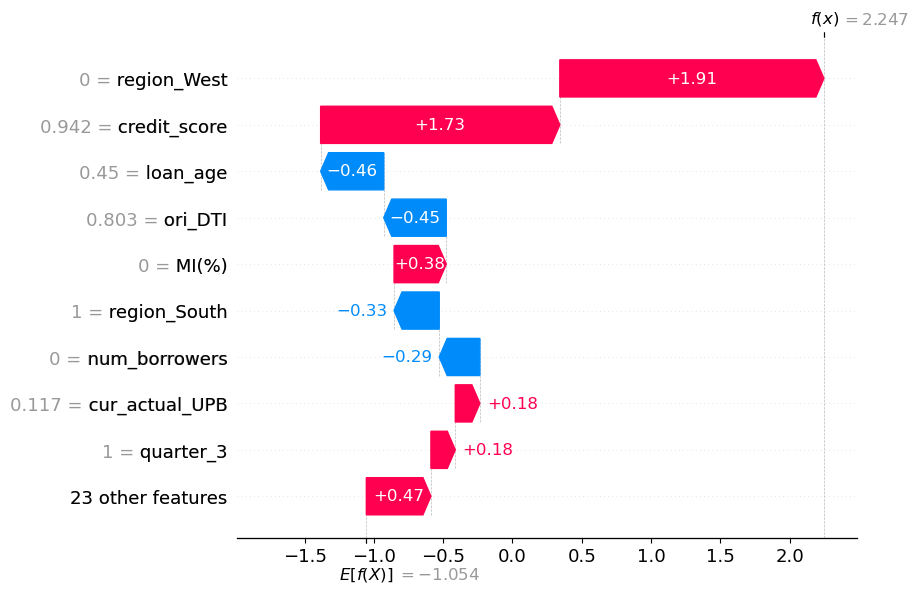

In [43]:
feature_importance_tree_in_processing(fair_lgb)

In [44]:
lgb_pred_fair_train = fair_lgb.predict(X_resampled).flatten()
lgb_pred_fair_val = fair_lgb.predict(X_val).flatten()
lgb_pred_fair = fair_lgb.predict(X_test).flatten()

for dataset, y_true, pred, protected in [
    ("Train", y_resampled, lgb_pred_fair_train, protected_attr),
    ("Validation", y_val, lgb_pred_fair_val, protected_attr_val),
    ("Test", y_test, lgb_pred_fair, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - LightGBM ===")
    fairness_metrics(y_true, pred, protected)
print_result2(fair_lgb, X_resampled, X_val, X_test)


=== Fairness Evaluation: Train Set - LightGBM ===
Demographic Parity:  0.3255
Equalized Odds: 0.3842
Disparate Impact: 0.8909

=== Fairness Evaluation: Validation Set - LightGBM ===
Demographic Parity:  0.0040
Equalized Odds: 0.1722
Disparate Impact: 0.9990

=== Fairness Evaluation: Test Set - LightGBM ===
Demographic Parity:  0.0253
Equalized Odds: 0.1556
Disparate Impact: 1.0071
Classification report of train set
               precision    recall  f1-score   support

       False       0.82      0.88      0.85     25843
        True       0.87      0.81      0.84     25843

    accuracy                           0.85     51686
   macro avg       0.85      0.85      0.85     51686
weighted avg       0.85      0.85      0.85     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.86      0.03      8736
        True       1.00      0.78      0.88   2587089

    accuracy                           0.78   2

### 8.3 CatBoost


In [61]:
fair_cat = ExponentiatedGradient(
    cat_model_best,
    constraints=EqualizedOdds()
)

fair_cat.fit(X_resampled, y_resampled, sensitive_features=protected_attr)

0:	learn: 0.5914772	total: 24ms	remaining: 4.77s
1:	learn: 0.5316471	total: 42.3ms	remaining: 4.19s
2:	learn: 0.5005397	total: 58.2ms	remaining: 3.82s
3:	learn: 0.4781188	total: 75.8ms	remaining: 3.71s
4:	learn: 0.4683698	total: 86.7ms	remaining: 3.38s
5:	learn: 0.4625090	total: 100ms	remaining: 3.24s
6:	learn: 0.4575932	total: 116ms	remaining: 3.21s
7:	learn: 0.4546837	total: 132ms	remaining: 3.17s
8:	learn: 0.4522560	total: 146ms	remaining: 3.09s
9:	learn: 0.4497606	total: 160ms	remaining: 3.03s
10:	learn: 0.4474623	total: 170ms	remaining: 2.92s
11:	learn: 0.4457569	total: 185ms	remaining: 2.9s
12:	learn: 0.4441236	total: 197ms	remaining: 2.83s
13:	learn: 0.4425095	total: 214ms	remaining: 2.84s
14:	learn: 0.4413027	total: 226ms	remaining: 2.79s
15:	learn: 0.4401022	total: 241ms	remaining: 2.77s
16:	learn: 0.4388565	total: 254ms	remaining: 2.73s
17:	learn: 0.4382016	total: 265ms	remaining: 2.68s
18:	learn: 0.4357359	total: 279ms	remaining: 2.66s
19:	learn: 0.4343177	total: 291ms	remai

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x000002BD9F84A610>,
                      estimator=<catboost.core.CatBoostClassifier object at 0x000002BDA97A7F90>,
                      nu=0.0007780759332458494)


 Validation Set


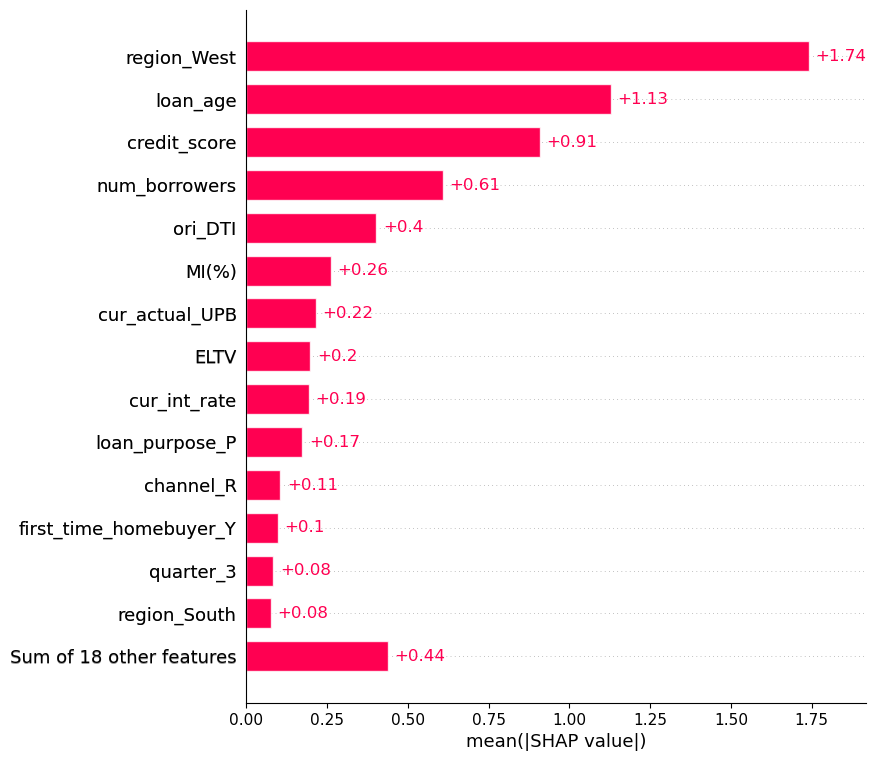


 Test Set


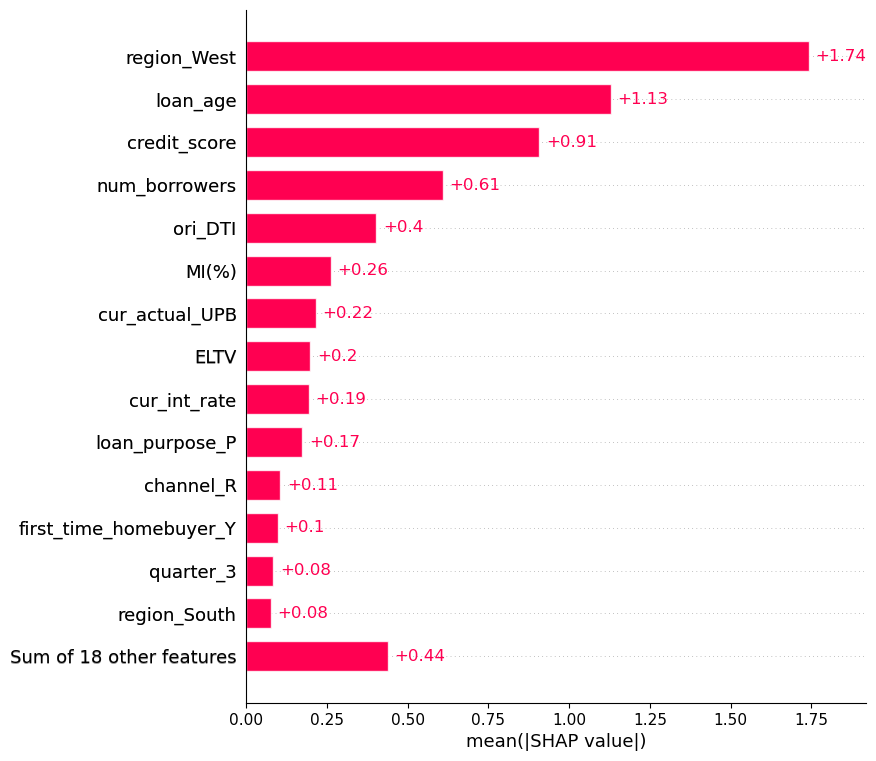


 Validation Set


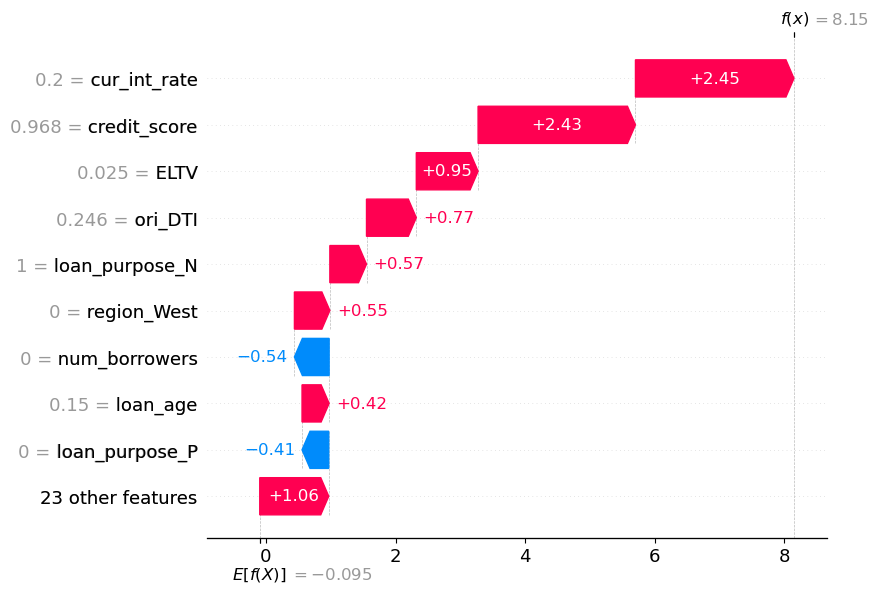


 Test Set


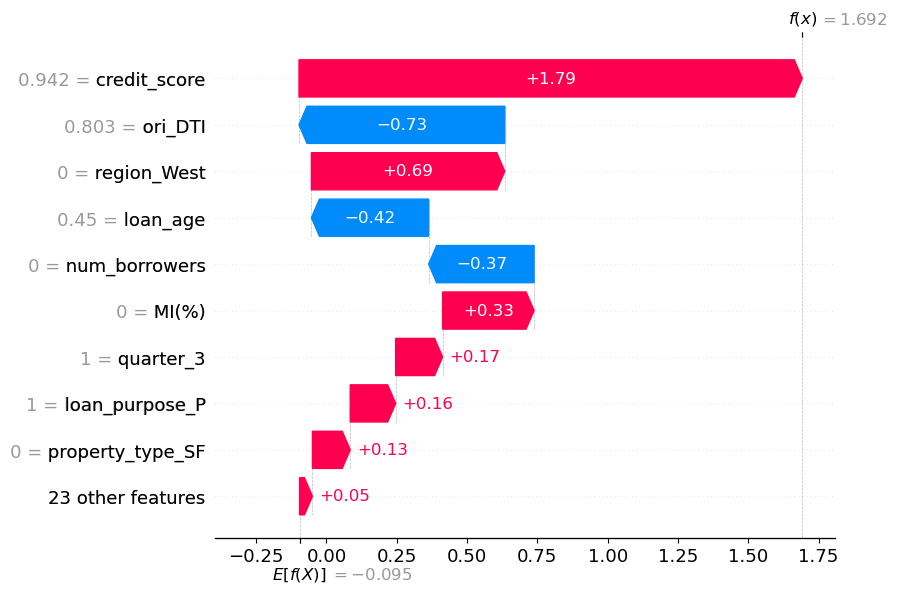

In [62]:
feature_importance_tree_in_processing(fair_cat)

In [63]:
cat_pred_fair_train = fair_cat.predict(X_resampled).flatten()
cat_pred_fair_val = fair_cat.predict(X_val).flatten()
cat_pred_fair = fair_cat.predict(X_test).flatten()

for dataset, y_true, pred, protected in [
    ("Train", y_resampled, cat_pred_fair_train, protected_attr),
    ("Validation", y_val, cat_pred_fair_val, protected_attr_val),
    ("Test", y_test, cat_pred_fair, protected_attr_test)
]:
    print(f"\n=== Fairness Evaluation: {dataset} Set - CatBoost ===")
    fairness_metrics(y_true, pred, protected)
print_result2(fair_cat, X_resampled, X_val, X_test)


=== Fairness Evaluation: Train Set - CatBoost ===
Demographic Parity:  0.2041
Equalized Odds: 0.3885
Disparate Impact: 0.9219

=== Fairness Evaluation: Validation Set - CatBoost ===
Demographic Parity:  0.0241
Equalized Odds: 0.1532
Disparate Impact: 1.0067

=== Fairness Evaluation: Test Set - CatBoost ===
Demographic Parity:  0.0517
Equalized Odds: 0.1602
Disparate Impact: 1.0168
Classification report of train set
               precision    recall  f1-score   support

       False       0.84      0.88      0.86     25843
        True       0.87      0.83      0.85     25843

    accuracy                           0.85     51686
   macro avg       0.85      0.85      0.85     51686
weighted avg       0.85      0.85      0.85     51686

Classification report of validation set
               precision    recall  f1-score   support

       False       0.01      0.85      0.03      8736
        True       1.00      0.79      0.88   2587089

    accuracy                           0.79   2

---
## 9.0 Fairness Post-processing
By using fairness post-processing algorithm, model interpretation and model evaluation are conducted and evaluated. 

In [48]:
def post_processing_fairness(model):
    postproc = ThresholdOptimizer(
        estimator=model, 
        constraints="equalized_odds",  
        predict_method="predict_proba",
        prefit=True
    )

    postproc.fit(X_resampled, y_resampled, sensitive_features=protected_attr)
    y_pred_train = postproc.predict(X_resampled, sensitive_features=protected_attr)
    y_pred_val = postproc.predict(X_val, sensitive_features=protected_attr_val)
    y_pred_test = postproc.predict(X_test, sensitive_features=protected_attr_test)
    
    if model==logReg_best:
        feature_importance_linear(model, X_resampled, X_val, X_test)
    elif model==lgb_model_best:
        feature_importance_tree(model, X_val, X_test)
    elif model==cat_model_best:
        feature_importance_tree(model, X_val, X_test)

    # Evaluate each set
    for name, X, y, y_pred, attr in [("Train", X_resampled, y_resampled, y_pred_train, protected_attr),
                                ("Validation", X_val, y_val, y_pred_val, protected_attr_val),
                                ("Test", X_test, y_test, y_pred_test, protected_attr_test)]:
        conf_matrix = confusion_matrix(y, y_pred)
        auc = roc_auc_score(y, model.predict_proba(X)[:, 1])  
        gmean = geometric_mean_score(y, y_pred)
        TN, FP= conf_matrix[0][0], conf_matrix[0][1]
        specificity = TN / (TN + FP)
        accuracy= accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
    
        print(f"\n=== {name} Set ===")
        print("Classification Report:\n", classification_report(y, y_pred))
        print(f"\nAccuracy: {accuracy:.4f}")
        print(f"\nSpecificity: {specificity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print("Confusion Matrix:\n", conf_matrix)
        print(f"Geometric Mean (G-Mean): {gmean:.4f}")

        fairness_metrics(y, y_pred,attr)
    return postproc

### 8.1 Logistic Regression

LinearExplainer explainer: 2595826it [00:24, 61139.18it/s]                              
LinearExplainer explainer: 2595826it [00:24, 62052.63it/s]                              



 Validation Set


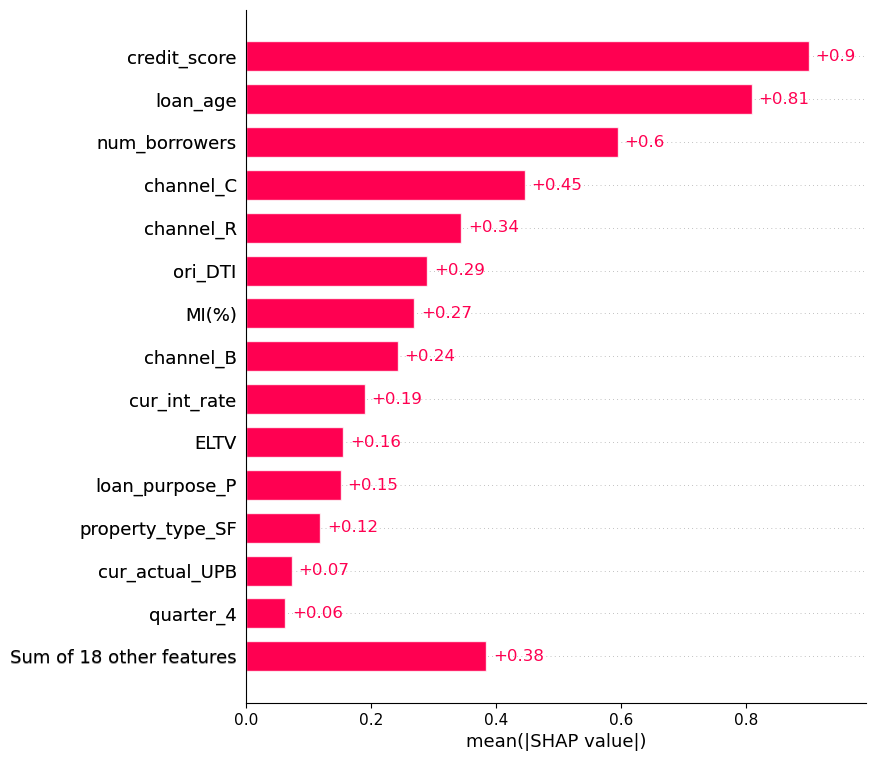


 Test Set


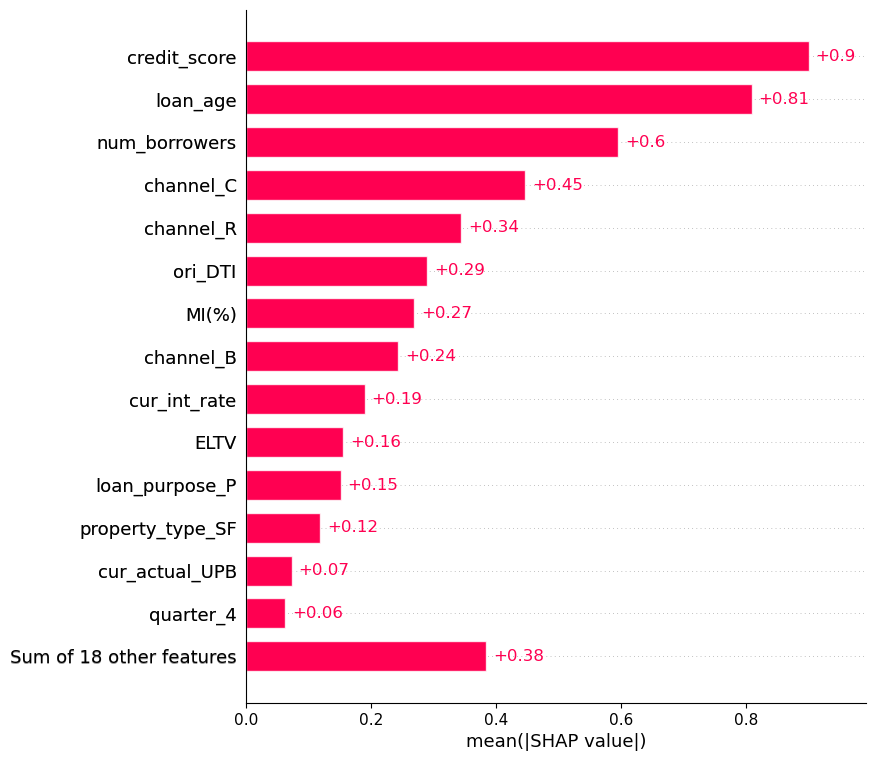


 Validation Set


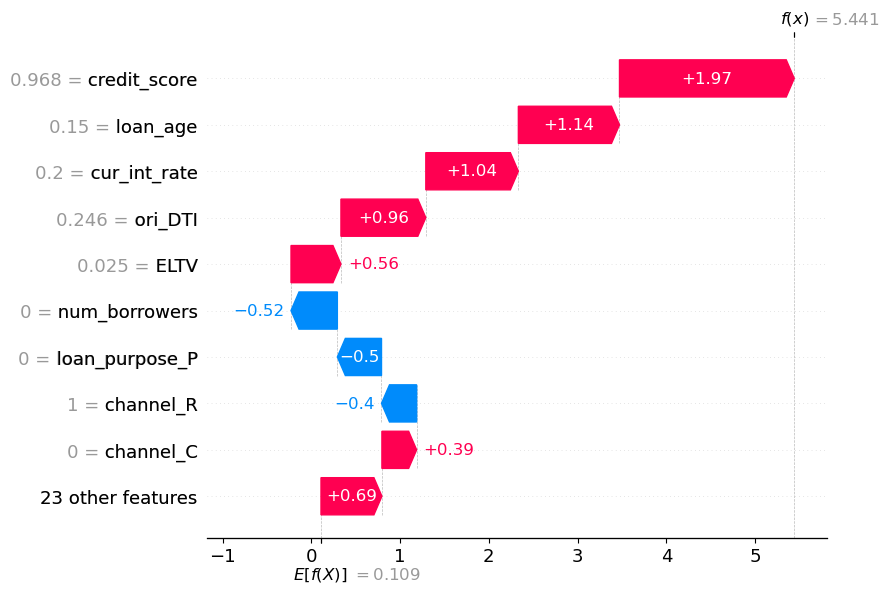


 Test Set


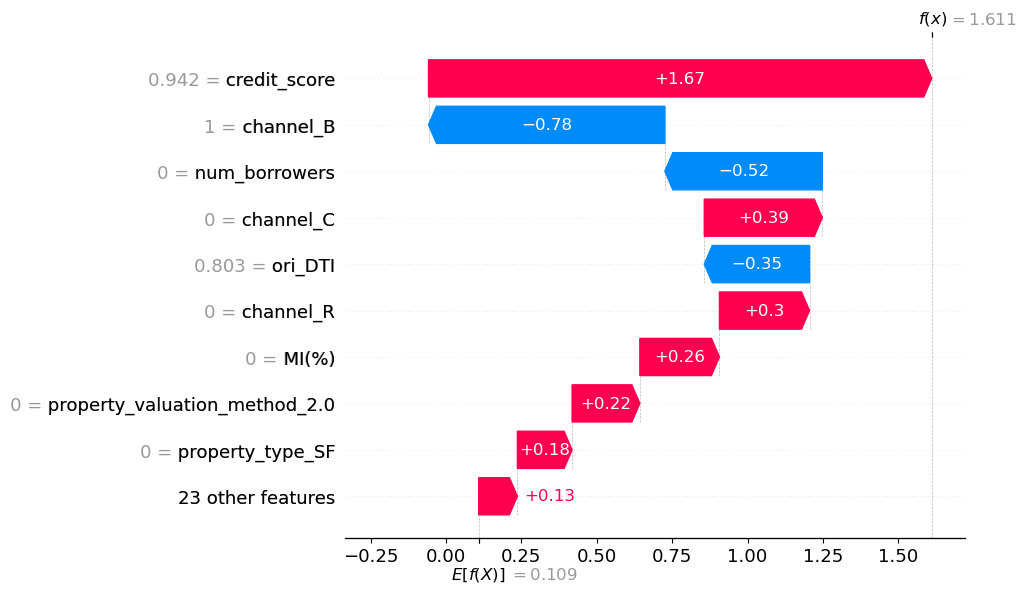


=== Train Set ===
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.82      0.79     25843
        True       0.81      0.75      0.78     25843

    accuracy                           0.79     51686
   macro avg       0.79      0.79      0.79     51686
weighted avg       0.79      0.79      0.79     51686


Accuracy: 0.7869

Specificity: 0.8206
Precision: 0.8077
Recall: 0.7532
F1 Score: 0.7795
AUC: 0.8609
Confusion Matrix:
 [[21208  4635]
 [ 6378 19465]]
Geometric Mean (G-Mean): 0.7862
Demographic Parity:  0.0361
Equalized Odds: 0.1826
Disparate Impact: 1.0076

=== Validation Set ===
Classification Report:
               precision    recall  f1-score   support

       False       0.01      0.82      0.02      8736
        True       1.00      0.75      0.86   2587089

    accuracy                           0.75   2595825
   macro avg       0.51      0.78      0.44   2595825
weighted avg       1.00      0.75      0.85   25958

In [49]:
postproc_logReg = post_processing_fairness(logReg_best)

### 8.2 LightGBM


 Validation Set


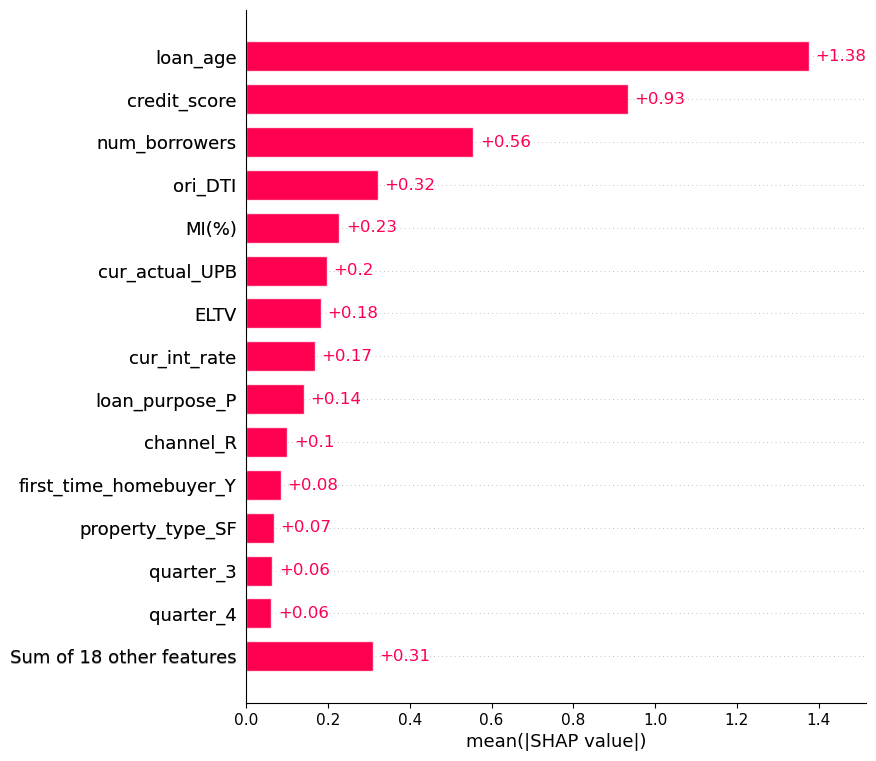


 Test Set


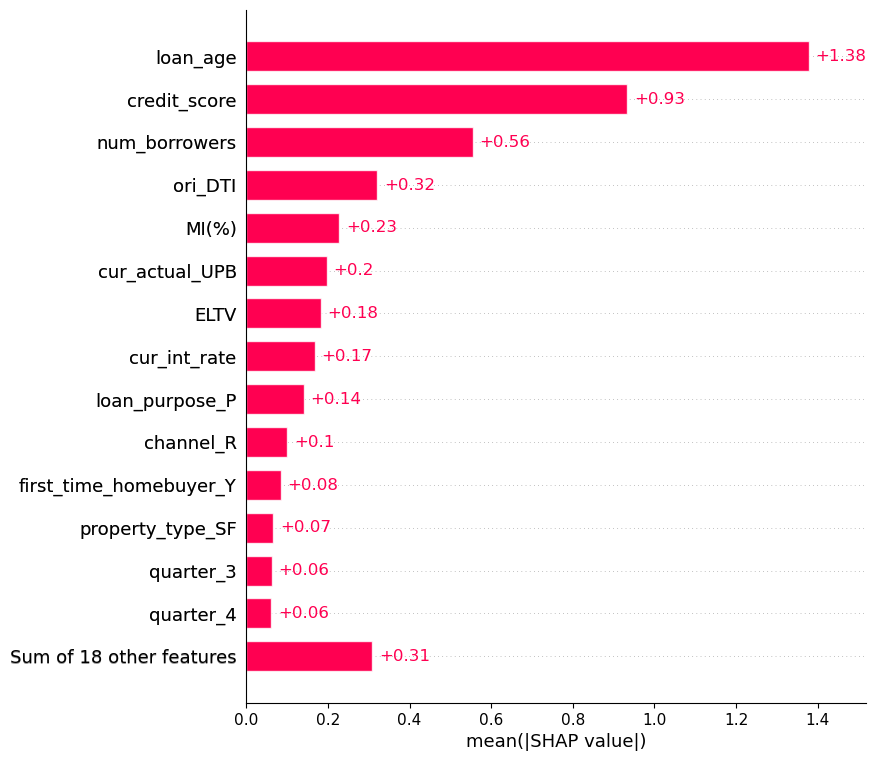


 Validation Set


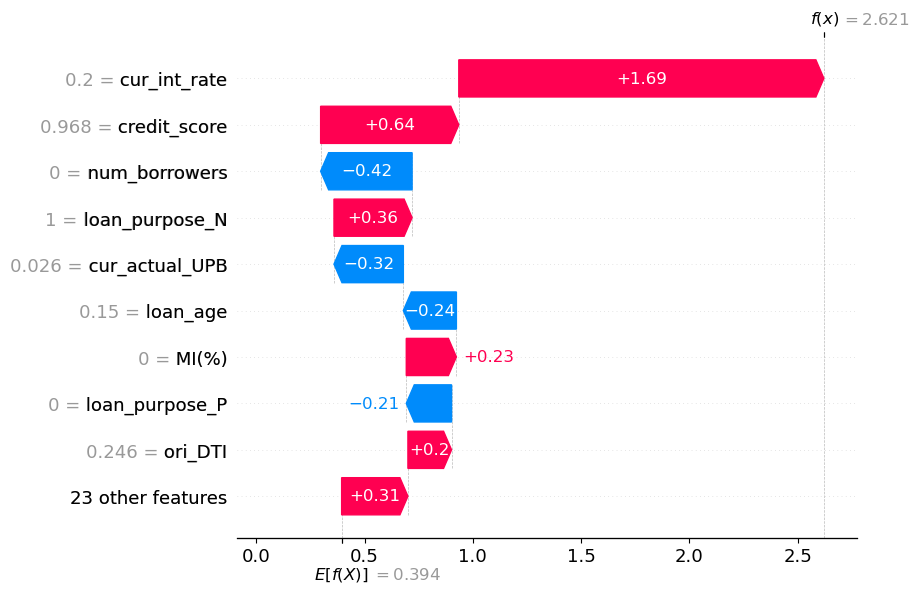


 Test Set


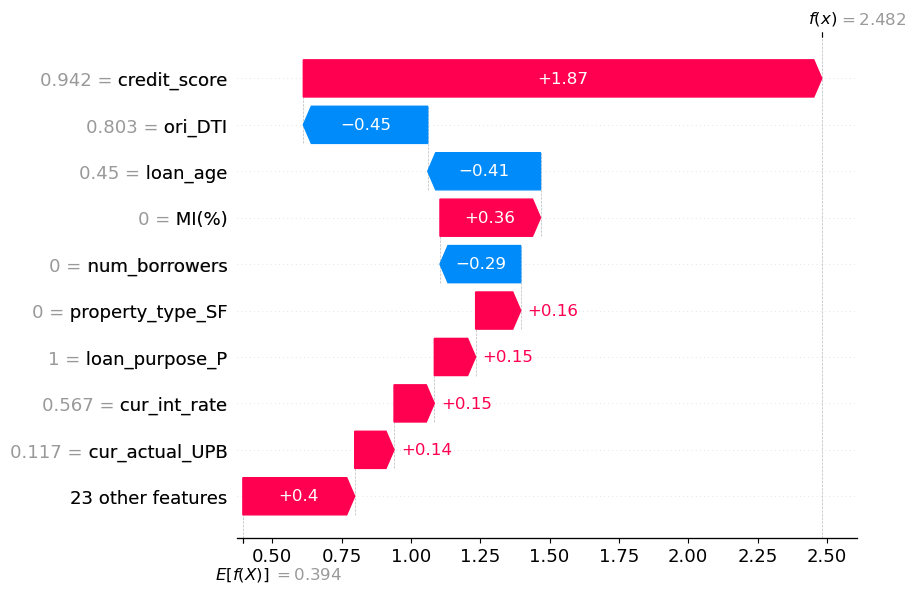


=== Train Set ===
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.87      0.85     25843
        True       0.86      0.82      0.84     25843

    accuracy                           0.84     51686
   macro avg       0.84      0.84      0.84     51686
weighted avg       0.84      0.84      0.84     51686


Accuracy: 0.8438

Specificity: 0.8659
Precision: 0.8597
Recall: 0.8217
F1 Score: 0.8402
AUC: 0.9218
Confusion Matrix:
 [[22377  3466]
 [ 4609 21234]]
Geometric Mean (G-Mean): 0.8435
Demographic Parity:  0.1615
Equalized Odds: 0.3942
Disparate Impact: 1.1036

=== Validation Set ===
Classification Report:
               precision    recall  f1-score   support

       False       0.01      0.84      0.03      8736
        True       1.00      0.79      0.88   2587089

    accuracy                           0.79   2595825
   macro avg       0.51      0.82      0.45   2595825
weighted avg       1.00      0.79      0.88   25958

In [50]:
postproc_lgb = post_processing_fairness(lgb_model_best)

### 8.3 CatBoost



 Validation Set


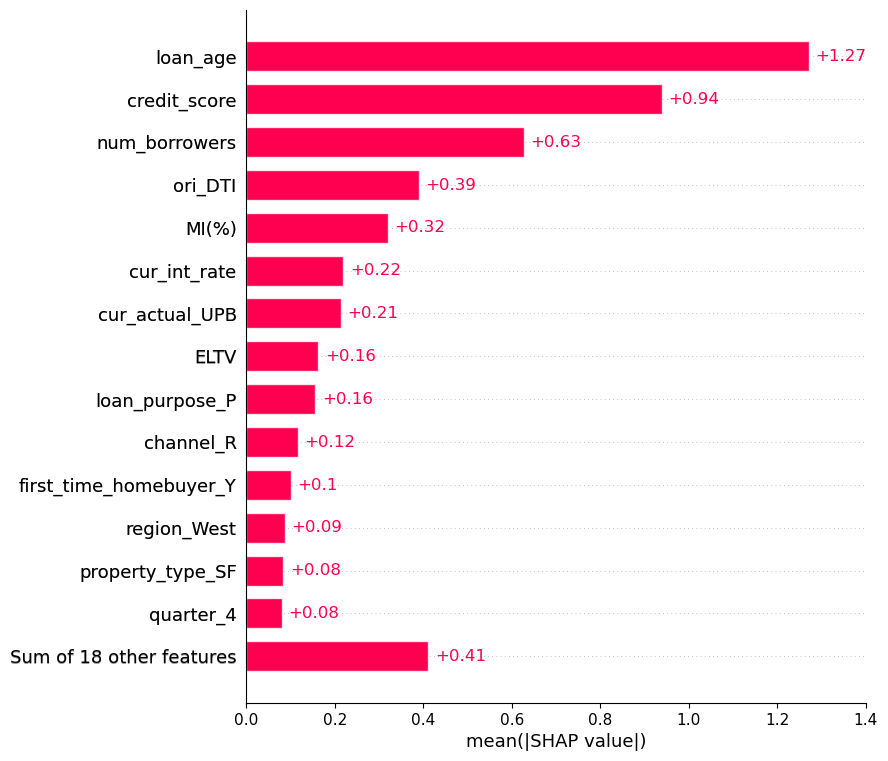


 Test Set


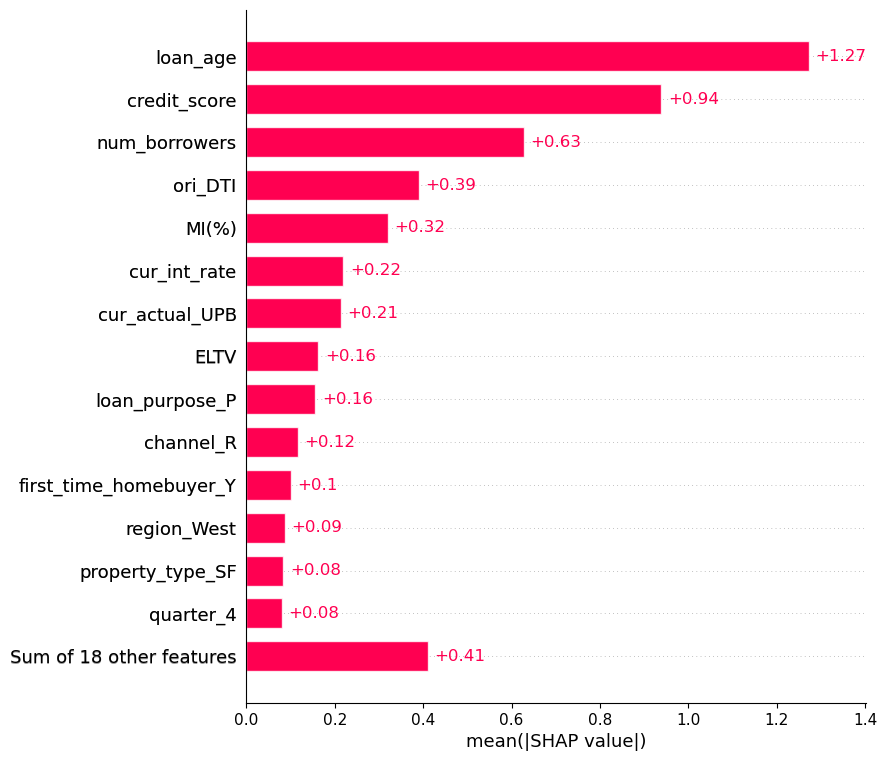


 Validation Set


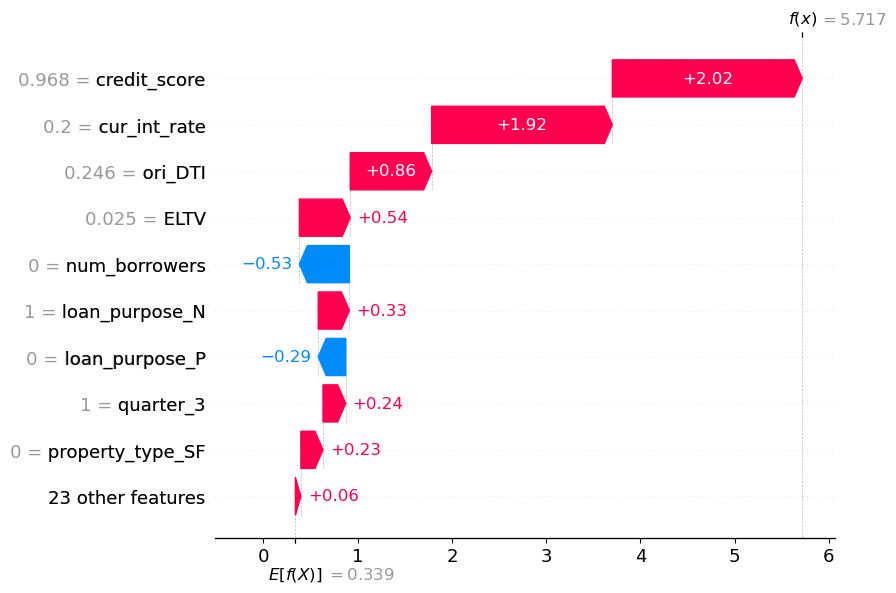


 Test Set


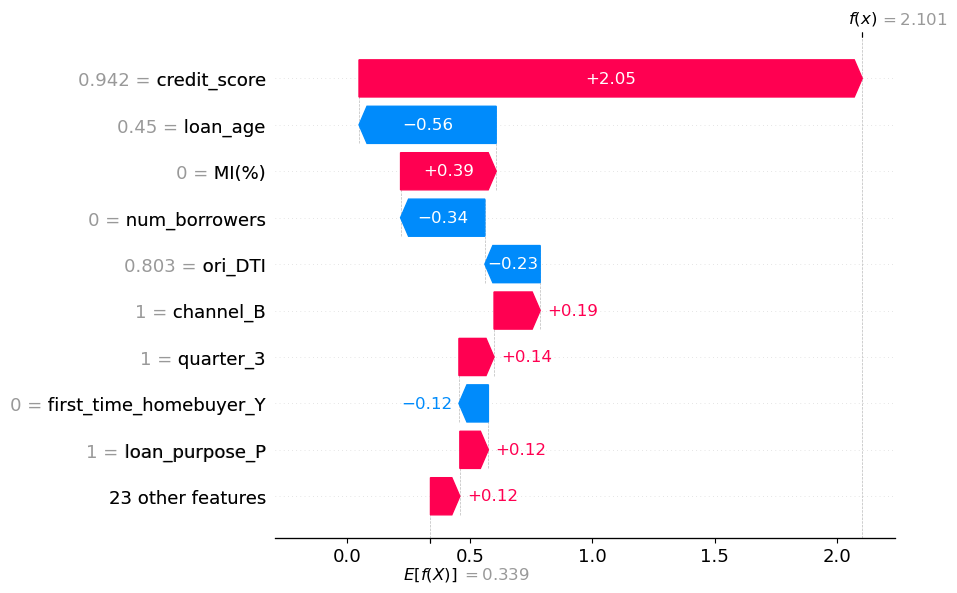


=== Train Set ===
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.87      0.85     25843
        True       0.86      0.83      0.85     25843

    accuracy                           0.85     51686
   macro avg       0.85      0.85      0.85     51686
weighted avg       0.85      0.85      0.85     51686


Accuracy: 0.8489

Specificity: 0.8704
Precision: 0.8646
Recall: 0.8273
F1 Score: 0.8456
AUC: 0.9268
Confusion Matrix:
 [[22495  3348]
 [ 4462 21381]]
Geometric Mean (G-Mean): 0.8486
Demographic Parity:  0.3077
Equalized Odds: 0.1734
Disparate Impact: 0.8989

=== Validation Set ===
Classification Report:
               precision    recall  f1-score   support

       False       0.01      0.84      0.03      8736
        True       1.00      0.79      0.88   2587089

    accuracy                           0.79   2595825
   macro avg       0.51      0.82      0.45   2595825
weighted avg       1.00      0.79      0.88   25958

In [64]:
postproc_cat = post_processing_fairness(cat_model_best)

#### Model with best balance between accuracy and fairness discrepancies: 
LightGBM with fairness in-processing

In [65]:
# Save best model
joblib.dump(fair_lgb, os.path.join(RESOURCES_DIR, "model_best.pkl"))

['../resources\\model_best.pkl']